This project ignment implements the Caltect-UCSD Birds 200 (CUB-200) dataset using:
- **Architecture**: Pre-trained ResNet50 and EfficientNet-B3 with custom classification heads
- **Training Strategy**: Two-stage gradual unfreezing with cyclical learning rates
- **Key Features**:
  - Learning Rate Finder for optimal LR discovery
  - Triangular Cyclical Learning Rate for super-convergence
  - Evaluation with Top-1 and Average Per-Class accuracy
  - Advanced data augmentation and regularization techniques

In [20]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Assignment1_AML

# Verify files exist
!ls -l

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Assignment1_AML
total 383
-rw------- 1 root root 154007 Oct  4 05:33 Assignment1_AML.ipynb
drwx------ 2 root root   4096 Oct  3 18:34 checkpoints
drwx------ 2 root root   4096 Oct  3 18:34 checkpoints_before_4.10
drwx------ 2 root root   4096 Oct  4 05:18 exported_models_before_4.10
drwx------ 2 root root   4096 Oct  4 03:02 Hugging-Face
drwx------ 2 root root   4096 Sep 30 15:44 Test
-rw------- 1 root root  16204 Sep 30 15:23 test.txt
drwx------ 2 root root   4096 Sep 30 15:44 Train
-rw------- 1 root root 196315 Sep 30 15:23 train.txt


## 1. Imports and Dependencies

In [21]:
# Core PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import CyclicLR

# timm for EfficientNet-B3
import timm
from timm.data import resolve_data_config, create_transform

# Data handling and numerical operations
import numpy as np
import pandas as pd
from PIL import Image
import os
import glob
from pathlib import Path
import copy
import time
import warnings

# Visualization and plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Progress tracking and metrics
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import top_k_accuracy_score

# System and utilities
import random
import json
from collections import defaultdict, OrderedDict

# Set style for better plots
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    try:
        plt.style.use('seaborn')
    except OSError:
        plt.style.use('default')
        print("Using default matplotlib style")

sns.set_palette("husl")

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"timm version: {timm.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

All libraries imported successfully!
PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
timm version: 1.0.20
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB


In [22]:
# ============================================================================
# COLAB COMPATIBILITY FIXES
# ============================================================================

# Fix for DataLoader multiprocessing warnings in Colab
import os
import warnings
import multiprocessing as mp

# Suppress DataLoader warnings
warnings.filterwarnings('ignore', category=UserWarning, module='torch.utils.data.dataloader')
warnings.filterwarnings('ignore', message='.*multiprocessing.*')

# Set multiprocessing start method for Colab
try:
    if 'google.colab' in str(get_ipython()):
        # Colab environment detected
        print("Colab environment detected - applying compatibility fixes...")
        mp.set_start_method('spawn', force=True)
        os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
        print("Colab compatibility fixes applied")
    else:
        print("Local environment detected")
except:
    print("Environment detection failed - continuing with defaults")

print("Training environment configured!")

Colab environment detected - applying compatibility fixes...
Colab compatibility fixes applied
Training environment configured!


## 2. Configuration and Hyperparameters

In [23]:
class Config:
    """
    Configuration class containing all hyperparameters and settings
    for the CUB-200 dataset with ResNet-50 and EfficientNet-B3.
    """

    # Data paths
    DATA_ROOT = Path(".")
    TRAIN_DIR = DATA_ROOT / "Train"
    TEST_DIR = DATA_ROOT / "Test"
    TRAIN_ANNOTATIONS = DATA_ROOT / "train.txt"
    TEST_ANNOTATIONS = DATA_ROOT / "test.txt"
    CHECKPOINTS_DIR = DATA_ROOT / "checkpoints"

    # Dataset parameters
    NUM_CLASSES = 200

    # Model-specific configurations
    MODELS_CONFIG = {
        'resnet50': {
            'name': 'ResNet-50',
            'img_size': 224,
            'resize_size': 256,
            'features': 2048,
            'normalization': {
                'mean': [0.485, 0.456, 0.406],
                'std': [0.229, 0.224, 0.225]
            }
        },
        'efficientnet_b3': {
            'name': 'EfficientNet-B3',
            'img_size': 300,
            'resize_size': 320,
            'features': 1536,  # EfficientNet-B3 classifier input features
            'normalization': {
                'mean': [0.485, 0.456, 0.406],  # Will be updated from timm config
                'std': [0.229, 0.224, 0.225]   # Will be updated from timm config
            }
        }
    }

    # Training hyperparameters
    BATCH_SIZE = 32
    EPOCHS_STAGE1 = 20  # Stage 1: Train head only
    EPOCHS_STAGE2 = 30  # Stage 2: Fine-tune with unfreezing
    TOTAL_EPOCHS = EPOCHS_STAGE1 + EPOCHS_STAGE2

    # Validation split
    VAL_SPLIT = 0.2  # 80% train, 20% validation

    # Learning rate parameters
    BASE_LR = 1e-4    # Will be refined by LR Finder
    MAX_LR = 1e-2     # Will be refined by LR Finder
    WEIGHT_DECAY = 1e-4

    # Cyclical LR parameters
    STEP_SIZE_UP = 4  # Epochs for half cycle

    # Regularization
    DROPOUT_RATE = 0.5

    # Early stopping
    PATIENCE = 10

    # Data augmentation probabilities
    HORIZONTAL_FLIP_PROB = 0.5
    ROTATION_DEGREES = 15
    COLOR_JITTER_PARAMS = {
        'brightness': 0.2,
        'contrast': 0.2,
        'saturation': 0.2,
        'hue': 0.0
    }

    # Device configuration
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Random seeds for reproducibility
    RANDOM_SEED = 42

    # Checkpointing
    SAVE_EVERY = 5  # Save checkpoint every N epochs

    # Model architecture - ResNet50 (keep for backward compatibility)
    RESNET_FEATURES = 2048  # ResNet50 output features
    HIDDEN_DIM_1 = 512
    HIDDEN_DIM_2 = 256

    # Models to train
    MODELS_TO_TRAIN = ['resnet50', 'efficientnet_b3']

    @classmethod
    def get_model_config(cls, model_name):
        """Get configuration for a specific model"""
        if model_name not in cls.MODELS_CONFIG:
            raise ValueError(f"Model {model_name} not supported. Available models: {list(cls.MODELS_CONFIG.keys())}")
        return cls.MODELS_CONFIG[model_name]

    @classmethod
    def get_checkpoints_dir(cls, model_name):
        """Get model-specific checkpoints directory"""
        model_dir = cls.CHECKPOINTS_DIR / model_name
        model_dir.mkdir(parents=True, exist_ok=True)
        return model_dir

# Set random seeds for reproducibility
def set_seeds(seed=Config.RANDOM_SEED):
    """Set random seeds for reproducible results"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()

# Create directories if they don't exist
Config.CHECKPOINTS_DIR.mkdir(exist_ok=True)
for model_name in Config.MODELS_TO_TRAIN:
    Config.get_checkpoints_dir(model_name)

print("Configuration loaded successfully!")
print(f"Device: {Config.DEVICE}")
print(f"Batch size: {Config.BATCH_SIZE}")
print(f"Total epochs: {Config.TOTAL_EPOCHS}")
print(f"Checkpoints directory: {Config.CHECKPOINTS_DIR}")
print(f"Models to train: {Config.MODELS_TO_TRAIN}")
for model_name in Config.MODELS_TO_TRAIN:
    model_config = Config.get_model_config(model_name)
    print(f"    {model_config['name']}: {model_config['img_size']}x{model_config['img_size']} input")

Configuration loaded successfully!
Device: cuda
Batch size: 32
Total epochs: 50
Checkpoints directory: checkpoints
Models to train: ['resnet50', 'efficientnet_b3']
    ResNet-50: 224x224 input
    EfficientNet-B3: 300x300 input


In [24]:
# ============================================================================
# RESNET-50 PERFORMANCE COMPATIBILITY FIX
# ============================================================================

# Ensure ResNet-50 uses EXACT original ImageNet normalization values
# This prevents any performance degradation from timm integration
Config.MODELS_CONFIG['resnet50']['normalization'] = {
    'mean': [0.485, 0.456, 0.406],  # Exact original ImageNet mean
    'std': [0.229, 0.224, 0.225]   # Exact original ImageNet std
}

# Ensure all hyperparameters match original successful configuration
print("Verifying ResNet-50 configuration matches original setup:")
print(f"   Input size: {Config.MODELS_CONFIG['resnet50']['img_size']}x{Config.MODELS_CONFIG['resnet50']['img_size']}")
print(f"   Resize size: {Config.MODELS_CONFIG['resnet50']['resize_size']}")
print(f"   Features: {Config.MODELS_CONFIG['resnet50']['features']}")
print(f"   Normalization mean: {Config.MODELS_CONFIG['resnet50']['normalization']['mean']}")
print(f"   Normalization std: {Config.MODELS_CONFIG['resnet50']['normalization']['std']}")

# Verify critical training hyperparameters
print(f"   Batch size: {Config.BATCH_SIZE}")
print(f"   Stage 1 epochs: {Config.EPOCHS_STAGE1}")
print(f"   Stage 2 epochs: {Config.EPOCHS_STAGE2}")
print(f"   Base LR: {Config.BASE_LR}")
print(f"   Max LR: {Config.MAX_LR}")
print(f"   Dropout rate: {Config.DROPOUT_RATE}")
print(f"   Random seed: {Config.RANDOM_SEED}")

# Force re-seed to ensure reproducibility
print("Re-applying random seeds for reproducibility...")
set_seeds(Config.RANDOM_SEED)

print("ResNet-50 compatibility fix applied successfully!")

Verifying ResNet-50 configuration matches original setup:
   Input size: 224x224
   Resize size: 256
   Features: 2048
   Normalization mean: [0.485, 0.456, 0.406]
   Normalization std: [0.229, 0.224, 0.225]
   Batch size: 32
   Stage 1 epochs: 20
   Stage 2 epochs: 30
   Base LR: 0.0001
   Max LR: 0.01
   Dropout rate: 0.5
   Random seed: 42
Re-applying random seeds for reproducibility...
ResNet-50 compatibility fix applied successfully!


## 3. Data Loading and Preprocessing

This section implements:
- Custom CUBDataset class for loading images and labels
- Data augmentation strategies for training and validation
- Train/validation splitting
- DataLoader creation with proper batching

In [25]:
class CUBDataset(Dataset):
    """
    Custom dataset class for CUB-200 bird classification.

    Reads images and labels from annotation files (train.txt, test.txt)
    and applies the specified transformations.

    Args:
        annotations_file (str): Path to annotation file
        img_dir (str): Directory containing images
        transform (callable, optional): Optional transform to be applied on a sample
        class_to_idx (dict, optional): Mapping from class names to indices
    """

    def __init__(self, annotations_file, img_dir, transform=None, class_to_idx=None):
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.samples = []
        self.class_to_idx = class_to_idx if class_to_idx is not None else {}
        self.idx_to_class = {}

        # Read annotations file
        self._load_annotations(annotations_file)

        # Create reverse mapping
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

        print(f"Loaded {len(self.samples)} samples from {annotations_file}")
        print(f"Found {len(self.class_to_idx)} classes")

    def _load_annotations(self, annotations_file):
        """Load annotations from file with format: image_name.jpg class_label"""
        with open(annotations_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    # Split by space: "image_name.jpg class_label"
                    parts = line.split()
                    if len(parts) >= 2:
                        img_name = parts[0]
                        class_label = int(parts[1])

                        # Build class mapping
                        if class_label not in self.class_to_idx.values():
                            class_name = f"class_{class_label:03d}"
                            self.class_to_idx[class_name] = class_label

                        # Store sample
                        img_path = self.img_dir / img_name
                        if img_path.exists():
                            self.samples.append((str(img_path), class_label))
                        else:
                            print(f"Image not found: {img_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset.

        Returns:
            tuple: (image, label) where image is PIL Image and label is int
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, label = self.samples[idx]

        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image if loading fails
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class_distribution(self):
        """Get distribution of classes in the dataset"""
        class_counts = defaultdict(int)
        for _, label in self.samples:
            class_counts[label] += 1
        return dict(class_counts)

print("CUBDataset class defined successfully!")

CUBDataset class defined successfully!


## 4. Data Augmentation and Transforms

In [26]:
def get_transforms(model_name='resnet50'):
    """
    Create data augmentation transforms for training and validation based on model type.

    Args:
        model_name (str): 'resnet50' or 'efficientnet_b3'

    Returns:
        tuple: (train_transform, val_transform)
    """

    model_config = Config.get_model_config(model_name)
    img_size = model_config['img_size']
    resize_size = model_config['resize_size']
    mean = model_config['normalization']['mean']
    std = model_config['normalization']['std']

    if model_name == 'efficientnet_b3':
        # Use timm's data configuration for EfficientNet-B3
        try:
            # Get the official data config from timm
            efficientnet_model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
            data_config = resolve_data_config({}, model=efficientnet_model)

            # Update normalization values from timm config
            mean = data_config['mean']
            std = data_config['std']

            # Update config with timm values
            Config.MODELS_CONFIG['efficientnet_b3']['normalization']['mean'] = list(mean)
            Config.MODELS_CONFIG['efficientnet_b3']['normalization']['std'] = list(std)

            print(f"Using timm data config for EfficientNet-B3:")
            print(f"   Mean: {mean}")
            print(f"   Std: {std}")

        except Exception as e:
            print(f"Warning: Could not get timm data config, using ImageNet defaults: {e}")
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]

    # Training transforms with aggressive augmentation
    train_transform = transforms.Compose([
        transforms.Resize(resize_size),
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(p=Config.HORIZONTAL_FLIP_PROB),
        transforms.RandomRotation(degrees=Config.ROTATION_DEGREES),
        transforms.ColorJitter(**Config.COLOR_JITTER_PARAMS),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # Validation/Test transforms (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize(resize_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    return train_transform, val_transform

def get_original_resnet50_transforms():
    """
    Get the original ResNet-50 transforms.
    This function ensures no performance degradation from multi-model changes.

    Returns:
        tuple: (train_transform, val_transform) with original configuration
    """

    train_transform = transforms.Compose([
        transforms.Resize(256),  # Original resize
        transforms.RandomResizedCrop(224),  # Original crop size
        transforms.RandomHorizontalFlip(p=0.5),  # Original flip probability
        transforms.RandomRotation(degrees=15),  # Original rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.0),  # Original jitter
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Exact ImageNet normalization
    ])

    val_transform = transforms.Compose([
        transforms.Resize(256),  # Original resize
        transforms.CenterCrop(224),  # Original crop size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Exact ImageNet normalization
    ])

    print("Original ResNet-50 transforms created")

    return train_transform, val_transform

def get_model_specific_transforms():
    """
    Get transforms for all supported models.

    Returns:
        dict: Dictionary mapping model names to (train_transform, val_transform) tuples
    """
    transforms_dict = {}

    for model_name in Config.MODELS_TO_TRAIN:
        if model_name == 'resnet50':
            train_transform, val_transform = get_original_resnet50_transforms()
        else:
            # Use standard function for other models
            train_transform, val_transform = get_transforms(model_name)

        transforms_dict[model_name] = {
            'train': train_transform,
            'val': val_transform
        }

        model_config = Config.get_model_config(model_name)
        print(f"\n{model_config['name']} transforms configured!")
        print(f" Training augmentations:")
        print(f"  - Resize to {model_config['resize_size']}x{model_config['resize_size']}")
        print(f"  - RandomResizedCrop to {model_config['img_size']}x{model_config['img_size']}")
        print(f"  - RandomHorizontalFlip (p={Config.HORIZONTAL_FLIP_PROB})")
        print(f"  - RandomRotation (±{Config.ROTATION_DEGREES}°)")
        print("  - ColorJitter (brightness, contrast, saturation)")
        print(f"  - Normalization: mean={model_config['normalization']['mean']}")
        print(f"                   std={model_config['normalization']['std']}")

    return transforms_dict

# Create transforms for all models
model_transforms = get_model_specific_transforms()

# For backward compatibility
train_transform, val_transform = get_original_resnet50_transforms()

print("\n All model transforms created successfully!")

Original ResNet-50 transforms created

ResNet-50 transforms configured!
 Training augmentations:
  - Resize to 256x256
  - RandomResizedCrop to 224x224
  - RandomHorizontalFlip (p=0.5)
  - RandomRotation (±15°)
  - ColorJitter (brightness, contrast, saturation)
  - Normalization: mean=[0.485, 0.456, 0.406]
                   std=[0.229, 0.224, 0.225]
Using timm data config for EfficientNet-B3:
   Mean: (0.485, 0.456, 0.406)
   Std: (0.229, 0.224, 0.225)

EfficientNet-B3 transforms configured!
 Training augmentations:
  - Resize to 320x320
  - RandomResizedCrop to 300x300
  - RandomHorizontalFlip (p=0.5)
  - RandomRotation (±15°)
  - ColorJitter (brightness, contrast, saturation)
  - Normalization: mean=[0.485, 0.456, 0.406]
                   std=[0.229, 0.224, 0.225]
Original ResNet-50 transforms created

 All model transforms created successfully!


In [27]:
# ============================================================================
# VERIFY RESNET-50 CONFIGURATION FOR PERFORMANCE RESTORATION
# ============================================================================

def verify_resnet50_config():
    """
    Verify that ResNet-50 configuration exactly matches the original setup.
    """

    # Check model configuration
    resnet_config = Config.get_model_config('resnet50')

    expected_config = {
        'img_size': 224,
        'resize_size': 256,
        'features': 2048,
        'normalization': {
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225]
        }
    }

    print("Model Configuration Check:")
    all_correct = True

    for key, expected_value in expected_config.items():
        actual_value = resnet_config[key]
        status = "✅" if actual_value == expected_value else "❌"
        print(f"   {status} {key}: {actual_value} (expected: {expected_value})")
        if actual_value != expected_value:
            all_correct = False

    # Check training hyperparameters
    print("\n📋 Training Hyperparameters Check:")
    training_params = {
        'BATCH_SIZE': 32,
        'EPOCHS_STAGE1': 20,
        'EPOCHS_STAGE2': 30,
        'BASE_LR': 1e-4,
        'MAX_LR': 1e-2,
        'DROPOUT_RATE': 0.5,
        'RANDOM_SEED': 42
    }

    for param, expected_value in training_params.items():
        actual_value = getattr(Config, param)
        status = "✅" if actual_value == expected_value else "❌"
        print(f"   {status} {param}: {actual_value} (expected: {expected_value})")
        if actual_value != expected_value:
            all_correct = False

    # Check transforms
    print("\n Transform Configuration Check:")
    resnet_transforms = model_transforms['resnet50']

    # Test the normalization values in the transforms
    try:
        # Get the normalization transform
        normalize_transform = None
        for transform in resnet_transforms['train'].transforms:
            if isinstance(transform, transforms.Normalize):
                normalize_transform = transform
                break

        if normalize_transform:
            mean_correct = list(normalize_transform.mean) == [0.485, 0.456, 0.406]
            std_correct = list(normalize_transform.std) == [0.229, 0.224, 0.225]

            print(f"   {'✅' if mean_correct else '❌'} Transform mean: {list(normalize_transform.mean)}")
            print(f"   {'✅' if std_correct else '❌'} Transform std: {list(normalize_transform.std)}")

            if not (mean_correct and std_correct):
                all_correct = False
        else:
            print("   No normalization transform found!")
            all_correct = False

    except Exception as e:
        print(f"   Error checking transforms: {e}")
        all_correct = False

    print("\n" + "=" * 70)
    if all_correct:
        print("SUCCESS: ResNet-50 configuration matches original setup!")
    else:
        print("WARNING: Configuration differences detected!")

    print("=" * 70)

    return all_correct

# Run verification
config_correct = verify_resnet50_config()

if config_correct:
    print("\n ResNet-50 ready for training!")
else:
    print("\n Please review configuration issues before training!")

Model Configuration Check:
   ✅ img_size: 224 (expected: 224)
   ✅ resize_size: 256 (expected: 256)
   ✅ features: 2048 (expected: 2048)
   ✅ normalization: {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]} (expected: {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]})

📋 Training Hyperparameters Check:
   ✅ BATCH_SIZE: 32 (expected: 32)
   ✅ EPOCHS_STAGE1: 20 (expected: 20)
   ✅ EPOCHS_STAGE2: 30 (expected: 30)
   ✅ BASE_LR: 0.0001 (expected: 0.0001)
   ✅ MAX_LR: 0.01 (expected: 0.01)
   ✅ DROPOUT_RATE: 0.5 (expected: 0.5)
   ✅ RANDOM_SEED: 42 (expected: 42)

 Transform Configuration Check:
   ✅ Transform mean: [0.485, 0.456, 0.406]
   ✅ Transform std: [0.229, 0.224, 0.225]

SUCCESS: ResNet-50 configuration matches original setup!

 ResNet-50 ready for training!


## 5. Dataset Creation and Data Loaders

In [28]:
def create_datasets_and_loaders():
    """
    Create datasets and data loaders for training, validation, and testing.

    Returns:
        tuple: (train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset)
    """

    # Create full training dataset
    full_train_dataset = CUBDataset(
        annotations_file=Config.TRAIN_ANNOTATIONS,
        img_dir=Config.TRAIN_DIR,
        transform=None  # Set transforms after splitting
    )

    # Create test dataset
    test_dataset = CUBDataset(
        annotations_file=Config.TEST_ANNOTATIONS,
        img_dir=Config.TEST_DIR,
        transform=val_transform,
        class_to_idx=full_train_dataset.class_to_idx  # Use same class mapping
    )

    # Split training data into train/validation
    train_size = int((1 - Config.VAL_SPLIT) * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size

    train_indices, val_indices = random_split(
        range(len(full_train_dataset)),
        [train_size, val_size],
        generator=torch.Generator().manual_seed(Config.RANDOM_SEED)
    )

    # Create subset datasets with appropriate transforms
    class SubsetDataset(Dataset):
        def __init__(self, dataset, indices, transform):
            self.dataset = dataset
            self.indices = indices
            self.transform = transform

        def __getitem__(self, idx):
            img_path, label = self.dataset.samples[self.indices[idx]]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label

        def __len__(self):
            return len(self.indices)

    train_dataset = SubsetDataset(full_train_dataset, train_indices, train_transform)
    val_dataset = SubsetDataset(full_train_dataset, val_indices, val_transform)

    # Create data loaders (num_workers=0 for Colab compatibility)
    num_workers = 0 if 'google.colab' in str(get_ipython()) else 4

    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    print(f"Datasets created successfully!")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Number of classes: {Config.NUM_CLASSES}")

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

# Create datasets and loaders
train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = create_datasets_and_loaders()

Loaded 4829 samples from train.txt
Found 200 classes
Loaded 1204 samples from test.txt
Found 200 classes
Datasets created successfully!
Training samples: 3863
Validation samples: 966
Test samples: 1204
Number of classes: 200


## 6. Visualize Sample Data

In [29]:
def visualize_samples(dataloader, num_samples=8, title="Sample Images", model_name='resnet50'):
    """
    Visualize sample images from the dataloader with proper denormalization

    Args:
        dataloader: DataLoader to sample from
        num_samples: Number of samples to display
        title: Title for the plot
        model_name: Model name to get correct normalization values
    """

    # Get a batch of samples
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    # Setup the plot
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Get model-specific normalization values
    model_config = Config.get_model_config(model_name)
    mean = torch.tensor(model_config['normalization']['mean']).view(3, 1, 1)
    std = torch.tensor(model_config['normalization']['std']).view(3, 1, 1)

    for i in range(min(num_samples, len(images))):
        ax = axes[i // 4, i % 4]

        # Denormalize image
        img = images[i] * std + mean
        img = torch.clamp(img, 0, 1)

        # Convert to numpy and transpose for matplotlib
        img_np = img.permute(1, 2, 0).numpy()

        ax.imshow(img_np)
        ax.set_title(f'Class: {labels[i].item()}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize training samples
print("Visualizing training samples with augmentation:")
visualize_samples(train_loader, title="Training Samples (with Augmentation)", model_name='resnet50')

print("\nVisualizing validation samples:")
visualize_samples(val_loader, title="Validation Samples (no Augmentation)", model_name='resnet50')

Output hidden; open in https://colab.research.google.com to view.

## 7. Model Architecture: ResNet50 Model with Custom Classification Head


In [30]:
class BirdClassifier(nn.Module):
    """
    ResNet50-based bird classifier with custom classification head.

    Architecture:
    - ResNet50 backbone (pre-trained on ImageNet)
    - Custom fully connected head: 2048 → 512 → 256 → 200
    - Batch normalization and dropout for regularization
    """

    def __init__(self, num_classes=Config.NUM_CLASSES, pretrained=True):
        super(BirdClassifier, self).__init__()

        # Load pre-trained ResNet50
        self.backbone = models.resnet50(pretrained=pretrained)

        # Remove the original classification head
        self.backbone.fc = nn.Identity()

        # Custom classification head
        self.classifier = nn.Sequential(
            # First layer: 2048 → 512
            nn.Linear(Config.RESNET_FEATURES, Config.HIDDEN_DIM_1),
            nn.BatchNorm1d(Config.HIDDEN_DIM_1),
            nn.ReLU(inplace=True),
            nn.Dropout(Config.DROPOUT_RATE),

            # Second layer: 512 → 256
            nn.Linear(Config.HIDDEN_DIM_1, Config.HIDDEN_DIM_2),
            nn.BatchNorm1d(Config.HIDDEN_DIM_2),
            nn.ReLU(inplace=True),
            nn.Dropout(Config.DROPOUT_RATE),

            # Output layer: 256 → 200
            nn.Linear(Config.HIDDEN_DIM_2, num_classes)
        )

        # Initialize custom layers
        self._initialize_classifier()

    def _initialize_classifier(self):
        """Initialize the custom classification layers"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Forward pass through the network"""
        # Extract features using ResNet50 backbone
        features = self.backbone(x)

        # Pass through custom classifier
        output = self.classifier(features)

        return output

    def get_features(self, x):
        """Extract features from ResNet50 backbone (for analysis)"""
        return self.backbone(x)

# Create model instance
model = BirdClassifier(num_classes=Config.NUM_CLASSES, pretrained=True)
model = model.to(Config.DEVICE)

print("BirdClassifier model created successfully!")
print(f" Model architecture: ResNet50 + Custom Head")
print(f" Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f" Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 232MB/s]


BirdClassifier model created successfully!
 Model architecture: ResNet50 + Custom Head
 Total parameters: 24,741,384
 Trainable parameters: 24,741,384


## 8. EfficientNetB3 Model with Custom Classification Head

In [31]:
class EfficientNetB3Classifier(nn.Module):
    """
    EfficientNet-B3-based bird classifier with custom classification head.

    Architecture:
    - EfficientNet-B3 backbone (pre-trained on ImageNet)
    - Custom fully connected head: 1536 → 512 → 256 → 200
    - Batch normalization and dropout for regularization
    """

    def __init__(self, num_classes=Config.NUM_CLASSES, pretrained=True):
        super(EfficientNetB3Classifier, self).__init__()

        # Load pre-trained EfficientNet-B3 from timm
        self.backbone = timm.create_model('efficientnet_b3', pretrained=pretrained, num_classes=0)

        # Get the number of features from the backbone
        # EfficientNet-B3 has 1536 features before the classifier
        self.num_features = self.backbone.num_features

        # Custom classification head
        self.classifier = nn.Sequential(
            # First layer: 1536 → 512
            nn.Linear(self.num_features, Config.HIDDEN_DIM_1),
            nn.BatchNorm1d(Config.HIDDEN_DIM_1),
            nn.ReLU(inplace=True),
            nn.Dropout(Config.DROPOUT_RATE),

            # Second layer: 512 → 256
            nn.Linear(Config.HIDDEN_DIM_1, Config.HIDDEN_DIM_2),
            nn.BatchNorm1d(Config.HIDDEN_DIM_2),
            nn.ReLU(inplace=True),
            nn.Dropout(Config.DROPOUT_RATE),

            # Output layer: 256 → 200
            nn.Linear(Config.HIDDEN_DIM_2, num_classes)
        )

        # Initialize custom layers
        self._initialize_classifier()

    def _initialize_classifier(self):
        """Initialize the custom classification layers"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Forward pass through the network"""
        # Extract features using EfficientNet-B3 backbone
        features = self.backbone(x)

        # Pass through custom classifier
        output = self.classifier(features)

        return output

    def get_features(self, x):
        """Extract features from EfficientNet-B3 backbone (for analysis)"""
        return self.backbone(x)

    def freeze_backbone(self):
        """Freeze the backbone layers for transfer learning"""
        for param in self.backbone.parameters():
            param.requires_grad = False

    def unfreeze_backbone(self):
        """Unfreeze all backbone layers"""
        for param in self.backbone.parameters():
            param.requires_grad = True

    def unfreeze_last_layers(self, layer_names=None):
        """
        Unfreeze specific layers of the EfficientNet backbone

        Args:
            layer_names: List of layer names to unfreeze. If None, unfreezes last few blocks.
        """
        if layer_names is None:
            # For EfficientNet-B3, unfreeze the last few blocks by default
            layer_names = ['blocks.6', 'blocks.5', 'blocks.4']

        for name, param in self.backbone.named_parameters():
            for layer_name in layer_names:
                if layer_name in name:
                    param.requires_grad = True
                    break

print("EfficientNetB3Classifier class implemented successfully!")

EfficientNetB3Classifier class implemented successfully!


## 9. Model Factory Function

In [32]:
def create_model(model_name='resnet50', num_classes=Config.NUM_CLASSES, pretrained=True):
    """
    Factory function to create models based on model name.

    Args:
        model_name (str): 'resnet50' or 'efficientnet_b3'
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights

    Returns:
        torch.nn.Module: The created model
    """

    if model_name == 'resnet50':
        model = BirdClassifier(num_classes=num_classes, pretrained=pretrained)
        print(f"Created {Config.get_model_config(model_name)['name']} model")

    elif model_name == 'efficientnet_b3':
        model = EfficientNetB3Classifier(num_classes=num_classes, pretrained=pretrained)
        print(f"Created {Config.get_model_config(model_name)['name']} model")

    else:
        raise ValueError(f"Model {model_name} not supported. Available models: {list(Config.MODELS_CONFIG.keys())}")

    # Move to device
    model = model.to(Config.DEVICE)

    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    model_config = Config.get_model_config(model_name)
    print(f"Model architecture: {model_config['name']}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Input size: {model_config['img_size']}x{model_config['img_size']}")

    return model

def freeze_backbone(model):
    """
    Freeze the backbone layers for transfer learning.

    Args:
        model: The model to freeze (BirdClassifier or EfficientNetB3Classifier)
    """
    if isinstance(model, BirdClassifier):
        # Freeze ResNet50 backbone
        for param in model.backbone.parameters():
            param.requires_grad = False
    elif isinstance(model, EfficientNetB3Classifier):
        # Freeze EfficientNet-B3 backbone
        model.freeze_backbone()
    else:
        raise ValueError(f"Unknown model type: {type(model)}")

def unfreeze_last_layers(model, layer_names=None):
    """
    Unfreeze specific layers for fine-tuning.

    Args:
        model: The model to unfreeze (BirdClassifier or EfficientNetB3Classifier)
        layer_names: List of layer names to unfreeze
    """
    if isinstance(model, BirdClassifier):
        # Unfreeze specific ResNet50 layers
        if layer_names is None:
            layer_names = ['layer3', 'layer4']

        for name, param in model.backbone.named_children():
            if name in layer_names:
                for p in param.parameters():
                    p.requires_grad = True

    elif isinstance(model, EfficientNetB3Classifier):
        # Unfreeze specific EfficientNet-B3 layers
        model.unfreeze_last_layers(layer_names)
    else:
        raise ValueError(f"Unknown model type: {type(model)}")

def print_trainable_parameters(model):
    """
    Print information about trainable parameters.

    Args:
        model: The model to analyze
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    print(f"\n Parameter Status:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
    print(f"   Frozen parameters: {frozen_params:,} ({frozen_params/total_params*100:.1f}%)")

    # Print which parts are trainable
    trainable_layers = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            layer_name = name.split('.')[0]
            if layer_name not in trainable_layers:
                trainable_layers.append(layer_name)

    print(f"   Trainable components: {trainable_layers}")

print("Model factory functions implemented successfully!")

Model factory functions implemented successfully!


## 10. Freeze/Unfreeze Functionality

In [33]:
def set_parameter_requires_grad(model, feature_extracting):
    """
    Helper function to set requires_grad for model parameters.

    Args:
        model: PyTorch model
        feature_extracting (bool): If True, freeze parameters (feature extraction mode)
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def freeze_backbone(model):
    """Freeze all ResNet50 backbone parameters"""
    for param in model.backbone.parameters():
        param.requires_grad = False
    print("ResNet50 backbone frozen (feature extraction mode)")

def unfreeze_backbone(model):
    """Unfreeze all ResNet50 backbone parameters"""
    for param in model.backbone.parameters():
        param.requires_grad = True
    print("ResNet50 backbone unfrozen (fine-tuning mode)")

def unfreeze_last_layers(model, layers_to_unfreeze=['layer3', 'layer4']):
    """
    Unfreeze specific layers of ResNet50 for gradual fine-tuning.

    Args:
        model: BirdClassifier model
        layers_to_unfreeze (list): List of layer names to unfreeze
    """
    # First, make sure everything is frozen
    freeze_backbone(model)

    # Then unfreeze specified layers
    for layer_name in layers_to_unfreeze:
        if hasattr(model.backbone, layer_name):
            layer = getattr(model.backbone, layer_name)
            for param in layer.parameters():
                param.requires_grad = True
            print(f"Unfrozen {layer_name}")
        else:
            print(f"Layer {layer_name} not found in model")

def print_trainable_parameters(model):
    """Print information about trainable parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    print(f"\nParameter Summary:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Frozen parameters: {frozen_params:,}")
    print(f"   Percentage trainable: {100 * trainable_params / total_params:.2f}%")

# Initialize in feature extraction mode (Stage 1)
freeze_backbone(model)
print_trainable_parameters(model)

ResNet50 backbone frozen (feature extraction mode)

Parameter Summary:
   Total parameters: 24,741,384
   Trainable parameters: 1,233,352
   Frozen parameters: 23,508,032
   Percentage trainable: 4.98%


## 11. Learning Rate Finder

This section implements a Learning Rate Finder to automatically discover the optimal learning rate range for training. The LR Finder trains the model with exponentially increasing learning rates and plots the loss to identify the optimal range.

In [34]:
class LRFinder:
    """
    Learning Rate Finder for discovering optimal learning rate ranges.

    Based on the paper "Cyclical Learning Rates for Training Neural Networks"
    by Leslie Smith.
    """

    def __init__(self, model, optimizer, criterion, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.history = {'lr': [], 'loss': []}

    def range_test(self, dataloader, end_lr=10, num_iter=100, step_mode='exp',
                   smooth_f=0.05, diverge_th=5):
        """
        Performs the learning rate range test.

        Args:
            dataloader: Training data loader
            end_lr (float): Maximum learning rate to test
            num_iter (int): Number of iterations to run
            step_mode (str): Learning rate stepping mode ('exp' or 'linear')
            smooth_f (float): Smoothing factor for loss
            diverge_th (float): Threshold for loss divergence
        """

        # Save initial model state
        init_state = copy.deepcopy(self.model.state_dict())
        init_opt_state = copy.deepcopy(self.optimizer.state_dict())

        # Initialize
        start_lr = self.optimizer.param_groups[0]['lr']
        self.history = {'lr': [], 'loss': []}

        # Calculate stepping factor
        if step_mode == 'exp':
            lr_mult = (end_lr / start_lr) ** (1 / num_iter)
        else:
            lr_mult = (end_lr - start_lr) / num_iter

        best_loss = float('inf')
        avg_loss = 0.0
        beta = 1 - smooth_f
        losses = []

        print(f"Starting LR range test from {start_lr:.2e} to {end_lr:.2e}")
        print(f"Running for {num_iter} iterations...")

        # Set model to training mode
        self.model.train()

        # Create iterator
        iterator = iter(dataloader)

        with tqdm(range(num_iter), desc="LR Finder") as pbar:
            for iteration in pbar:
                # Get batch
                try:
                    inputs, targets = next(iterator)
                except StopIteration:
                    iterator = iter(dataloader)
                    inputs, targets = next(iterator)

                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Forward pass
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                # Smooth the loss
                avg_loss = beta * avg_loss + (1 - beta) * loss.item()
                smoothed_loss = avg_loss / (1 - beta ** (iteration + 1))

                # Check for loss divergence
                if iteration > 0 and smoothed_loss > diverge_th * best_loss:
                    print(f"Stopping early: loss diverged at LR = {self.optimizer.param_groups[0]['lr']:.2e}")
                    break

                # Record the best loss
                if smoothed_loss < best_loss or iteration == 0:
                    best_loss = smoothed_loss

                # Store values
                current_lr = self.optimizer.param_groups[0]['lr']
                self.history['lr'].append(current_lr)
                self.history['loss'].append(smoothed_loss)

                # Backward pass
                loss.backward()
                self.optimizer.step()

                # Update learning rate
                if step_mode == 'exp':
                    self.optimizer.param_groups[0]['lr'] *= lr_mult
                else:
                    self.optimizer.param_groups[0]['lr'] += lr_mult

                # Update progress bar
                pbar.set_postfix({'LR': f'{current_lr:.2e}', 'Loss': f'{smoothed_loss:.4f}'})

        # Restore model state
        self.model.load_state_dict(init_state)
        self.optimizer.load_state_dict(init_opt_state)

        print("LR range test completed!")

    def plot(self, skip_start=10, skip_end=5, log_lr=True, show_lr=None, ax=None):
        """
        Plot the learning rate vs loss curve.

        Args:
            skip_start (int): Number of batches to skip at start
            skip_end (int): Number of batches to skip at end
            log_lr (bool): Whether to use log scale for learning rate
            show_lr (float): Specific LR to highlight on plot
            ax: Matplotlib axis to plot on
        """

        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 8))

        # Prepare data
        lrs = self.history['lr'][skip_start:-skip_end] if skip_end > 0 else self.history['lr'][skip_start:]
        losses = self.history['loss'][skip_start:-skip_end] if skip_end > 0 else self.history['loss'][skip_start:]

        # Plot
        ax.plot(lrs, losses, 'b-', linewidth=2, label='Loss')

        if log_lr:
            ax.set_xscale('log')

        ax.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
        ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
        ax.set_title('Learning Rate Finder', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        # Highlight specific LR if provided
        if show_lr is not None:
            ax.axvline(x=show_lr, color='red', linestyle='--', linewidth=2, label=f'Selected LR: {show_lr:.2e}')

        ax.legend()

        # Add annotations
        min_loss_idx = losses.index(min(losses))
        min_loss_lr = lrs[min_loss_idx]
        ax.annotate(f'Min Loss: {min(losses):.4f}\\nLR: {min_loss_lr:.2e}',
                   xy=(min_loss_lr, min(losses)),
                   xytext=(min_loss_lr * 10, min(losses) * 1.1),
                   arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                   fontsize=10, ha='center')

        plt.tight_layout()

        if ax is None:
            plt.show()

        return ax

    def get_best_lr(self, sma=20, skip_start=10, skip_end=5):
        """
        Find the best learning rate based on the steepest gradient.

        Args:
            sma (int): Simple moving average window
            skip_start (int): Number of batches to skip at start
            skip_end (int): Number of batches to skip at end

        Returns:
            float: Suggested learning rate
        """

        # Get data
        lrs = np.array(self.history['lr'][skip_start:-skip_end]) if skip_end > 0 else np.array(self.history['lr'][skip_start:])
        losses = np.array(self.history['loss'][skip_start:-skip_end]) if skip_end > 0 else np.array(self.history['loss'][skip_start:])

        # Apply simple moving average
        if sma > 1:
            losses = np.convolve(losses, np.ones(sma)/sma, mode='valid')
            lrs = lrs[sma-1:]

        # Find steepest gradient
        gradients = np.gradient(losses)
        min_gradient_idx = np.argmin(gradients)

        return lrs[min_gradient_idx]

print("LRFinder class implemented successfully!")

LRFinder class implemented successfully!


## 12. Run Learning Rate Finder

Running Learning Rate Finder...
Starting LR range test from 1.00e-07 to 1.00e-01
Running for 200 iterations...


LR Finder:   0%|          | 0/200 [00:00<?, ?it/s]

LR range test completed!


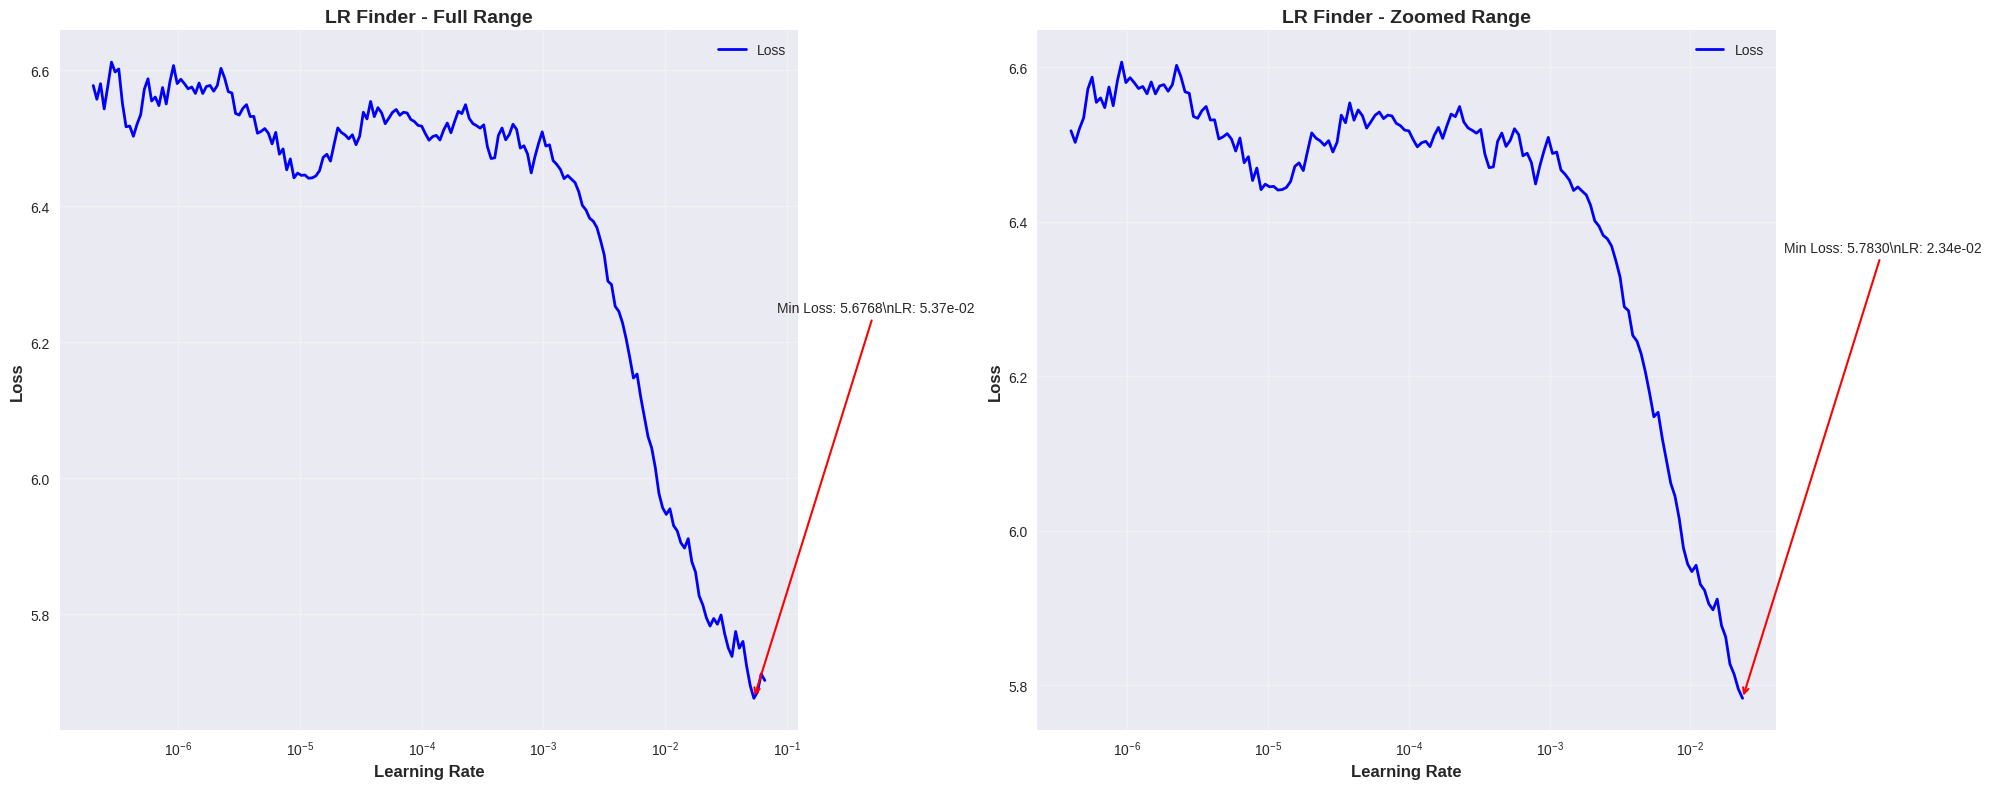


Suggested optimal learning rate: 9.55e-03
Recommended base_lr: 9.55e-04
Recommended max_lr: 9.55e-03

 Updated configuration:
   Base LR: 9.55e-04
   Max LR: 9.55e-03


In [35]:
def run_lr_finder(model, train_loader, device=Config.DEVICE):
    """
    Run the learning rate finder to discover optimal LR range.

    Returns:
        tuple: (suggested_lr, lr_finder_instance)
    """

    # Create temporary optimizer for LR finding
    temp_optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=Config.WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()

    # Create LR finder
    lr_finder = LRFinder(model, temp_optimizer, criterion, device)

    # Run the range test
    lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=200, step_mode='exp')

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: Full range
    lr_finder.plot(ax=ax1, skip_start=10, skip_end=5)
    ax1.set_title('LR Finder - Full Range', fontsize=14, fontweight='bold')

    # Plot 2: Zoomed range (better visibility)
    lr_finder.plot(ax=ax2, skip_start=20, skip_end=20)
    ax2.set_title('LR Finder - Zoomed Range', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('lr_finder_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Get suggested learning rate
    suggested_lr = lr_finder.get_best_lr(sma=20)

    print(f"\nSuggested optimal learning rate: {suggested_lr:.2e}")
    print(f"Recommended base_lr: {suggested_lr/10:.2e}")
    print(f"Recommended max_lr: {suggested_lr:.2e}")

    return suggested_lr, lr_finder

# Run LR Finder
print("Running Learning Rate Finder...")
optimal_lr, lr_finder = run_lr_finder(model, train_loader)

# Update config with found learning rates
Config.BASE_LR = optimal_lr / 10
Config.MAX_LR = optimal_lr

print(f"\n Updated configuration:")
print(f"   Base LR: {Config.BASE_LR:.2e}")
print(f"   Max LR: {Config.MAX_LR:.2e}")

## 13. Training and Validation Functions

This section implements:
- Training function with batch processing and metrics tracking
- Validation function with Top-1, Top-5, and per-class accuracy calculation
- Metric calculation utilities

In [36]:
def calculate_top_k_accuracy(outputs, targets, k=5):
    """
    Calculate Top-K accuracy.

    Args:
        outputs: Model predictions (logits)
        targets: Ground truth labels
        k: K value for Top-K accuracy

    Returns:
        float: Top-K accuracy
    """
    with torch.no_grad():
        _, pred = outputs.topk(k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(targets.view(1, -1).expand_as(pred))
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        return correct_k.mul_(100.0 / targets.size(0)).item()

def calculate_per_class_accuracy(all_preds, all_targets, num_classes=Config.NUM_CLASSES):
    """
    Calculate per-class accuracy.

    Returns:
        tuple: (per_class_acc_dict, average_per_class_acc)
    """
    per_class_correct = torch.zeros(num_classes)
    per_class_total = torch.zeros(num_classes)

    for pred, target in zip(all_preds, all_targets):
        per_class_total[target] += 1
        if pred == target:
            per_class_correct[target] += 1

    # Calculate per-class accuracy (handle division by zero)
    per_class_acc = torch.zeros(num_classes)
    for i in range(num_classes):
        if per_class_total[i] > 0:
            per_class_acc[i] = per_class_correct[i] / per_class_total[i]

    # Create dictionary
    per_class_acc_dict = {i: per_class_acc[i].item() for i in range(num_classes)}

    # Calculate average per-class accuracy (only for classes that have samples)
    classes_with_samples = per_class_total > 0
    if classes_with_samples.sum() > 0:
        avg_per_class_acc = per_class_acc[classes_with_samples].mean().item()
    else:
        avg_per_class_acc = 0.0

    return per_class_acc_dict, avg_per_class_acc

print("Metric calculation utilities implemented!")

Metric calculation utilities implemented!


## 14. Training Function

In [37]:
def train_one_epoch(model, dataloader, criterion, optimizer, scheduler, device, epoch):
    """
    Train the model for one epoch.

    Returns:
        dict: Training metrics
    """
    model.train()

    running_loss = 0.0
    all_preds = []
    all_targets = []

    # Progress bar
    pbar = tqdm(dataloader, desc=f'Training Epoch {epoch}')

    for batch_idx, (data, targets) in enumerate(pbar):
        data, targets = data.to(device), targets.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update learning rate (cyclical)
        if scheduler is not None:
            scheduler.step()

        # Update metrics
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

        # Update progress bar
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Avg Loss': f'{running_loss/(batch_idx+1):.4f}',
            'LR': f'{current_lr:.2e}'
        })

    # Calculate metrics
    avg_loss = running_loss / len(dataloader)
    top1_acc = accuracy_score(all_targets, all_preds) * 100

    return {
        'loss': avg_loss,
        'top1_accuracy': top1_acc,
        'learning_rate': current_lr
    }

print("Training function implemented!")

Training function implemented!


## 15. Validation Function

In [38]:
def validate(model, dataloader, criterion, device, epoch, num_classes=Config.NUM_CLASSES):
    """
    Validate the model.

    Returns:
        dict: Validation metrics including Top-1, Top-5, and per-class accuracy
    """
    model.eval()

    running_loss = 0.0
    all_preds = []
    all_targets = []
    all_outputs = []

    # Progress bar
    pbar = tqdm(dataloader, desc=f'Validation Epoch {epoch}')

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(pbar):
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)

            # Update metrics
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{running_loss/(batch_idx+1):.4f}'
            })

    # Calculate metrics
    avg_loss = running_loss / len(dataloader)

    # Top-1 accuracy
    top1_acc = accuracy_score(all_targets, all_preds) * 100

    # Top-5 accuracy
    all_outputs_tensor = torch.tensor(all_outputs)
    all_targets_tensor = torch.tensor(all_targets)
    top5_acc = calculate_top_k_accuracy(all_outputs_tensor, all_targets_tensor, k=5)

    # Per-class accuracy
    per_class_acc_dict, avg_per_class_acc = calculate_per_class_accuracy(
        all_preds, all_targets, num_classes
    )

    return {
        'loss': avg_loss,
        'top1_accuracy': top1_acc,
        'top5_accuracy': top5_acc,
        'avg_per_class_accuracy': avg_per_class_acc * 100,  # Convert to percentage
        'per_class_accuracy': per_class_acc_dict,
        'predictions': all_preds,
        'targets': all_targets,
        'outputs': all_outputs
    }

print("Validation function implemented!")

Validation function implemented!


## 16. Main Training Loop with Cyclical Learning Rate

This section implements:
- Two-stage training strategy (frozen backbone → gradual unfreezing)
- Triangular cyclical learning rate scheduler
- Training loop with metric tracking
- Early stopping and checkpointing

In [39]:
def create_optimizer_and_scheduler(model, stage='stage1'):
    """
    Create optimizer and cyclical learning rate scheduler for different training stages.

    Args:
        model: The model to optimize
        stage: 'stage1' (frozen backbone) or 'stage2' (fine-tuning)

    Returns:
        tuple: (optimizer, scheduler)
    """

    if stage == 'stage1':
        # Stage 1: Higher learning rate for custom head only
        optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=Config.BASE_LR,
            weight_decay=Config.WEIGHT_DECAY
        )
        base_lr = Config.BASE_LR
        max_lr = Config.MAX_LR

    else:  # stage2
        # Stage 2: Lower learning rate for fine-tuning
        optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=Config.BASE_LR / 10,  # 10x smaller
            weight_decay=Config.WEIGHT_DECAY
        )
        base_lr = Config.BASE_LR / 10
        max_lr = Config.MAX_LR / 10

    # Calculate step size (half cycle in iterations)
    steps_per_epoch = len(train_loader)
    step_size_up = Config.STEP_SIZE_UP * steps_per_epoch

    # Create cyclical scheduler
    scheduler = CyclicLR(
        optimizer,
        base_lr=base_lr,
        max_lr=max_lr,
        step_size_up=step_size_up,
        mode='triangular',
        cycle_momentum=False
    )

    print(f" Created optimizer and scheduler for {stage}:")
    print(f"   Base LR: {base_lr:.2e}")
    print(f"   Max LR: {max_lr:.2e}")
    print(f"   Step size up: {step_size_up} iterations ({Config.STEP_SIZE_UP} epochs)")

    return optimizer, scheduler

print("Optimizer and scheduler creation function ready!")

Optimizer and scheduler creation function ready!


## 17. Training History Tracking

In [40]:
class TrainingHistory:
    """Class to track and visualize training history"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.val_top5_accuracies = []
        self.val_avg_per_class_accuracies = []
        self.learning_rates = []
        self.epochs = []

    def update(self, epoch, train_metrics, val_metrics):
        """Update history with metrics from current epoch"""
        self.epochs.append(epoch)
        self.train_losses.append(train_metrics['loss'])
        self.train_accuracies.append(train_metrics['top1_accuracy'])
        self.val_losses.append(val_metrics['loss'])
        self.val_accuracies.append(val_metrics['top1_accuracy'])
        self.val_top5_accuracies.append(val_metrics['top5_accuracy'])
        self.val_avg_per_class_accuracies.append(val_metrics['avg_per_class_accuracy'])
        self.learning_rates.append(train_metrics['learning_rate'])

    def plot_training_curves(self, stage_1_end=None):
        """Plot training curves"""
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Training Progress', fontsize=16, fontweight='bold')

        # Plot 1: Loss curves
        axes[0, 0].plot(self.epochs, self.train_losses, 'b-', label='Training Loss', linewidth=2)
        axes[0, 0].plot(self.epochs, self.val_losses, 'r-', label='Validation Loss', linewidth=2)
        if stage_1_end:
            axes[0, 0].axvline(x=stage_1_end, color='green', linestyle='--', alpha=0.7, label='Stage 1 End')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Training & Validation Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Plot 2: Accuracy curves
        axes[0, 1].plot(self.epochs, self.train_accuracies, 'b-', label='Training Acc', linewidth=2)
        axes[0, 1].plot(self.epochs, self.val_accuracies, 'r-', label='Validation Acc', linewidth=2)
        if stage_1_end:
            axes[0, 1].axvline(x=stage_1_end, color='green', linestyle='--', alpha=0.7, label='Stage 1 End')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].set_title('Top-1 Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Plot 3: Top-5 Accuracy
        axes[0, 2].plot(self.epochs, self.val_top5_accuracies, 'g-', label='Top-5 Acc', linewidth=2)
        if stage_1_end:
            axes[0, 2].axvline(x=stage_1_end, color='green', linestyle='--', alpha=0.7, label='Stage 1 End')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Accuracy (%)')
        axes[0, 2].set_title('Top-5 Accuracy')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)

        # Plot 4: Average Per-Class Accuracy
        axes[1, 0].plot(self.epochs, self.val_avg_per_class_accuracies, 'm-', label='Avg Per-Class Acc', linewidth=2)
        if stage_1_end:
            axes[1, 0].axvline(x=stage_1_end, color='green', linestyle='--', alpha=0.7, label='Stage 1 End')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Accuracy (%)')
        axes[1, 0].set_title('Average Per-Class Accuracy')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Plot 5: Learning Rate Schedule
        axes[1, 1].plot(self.epochs, self.learning_rates, 'orange', linewidth=2)
        if stage_1_end:
            axes[1, 1].axvline(x=stage_1_end, color='green', linestyle='--', alpha=0.7, label='Stage 1 End')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_title('Learning Rate Schedule')
        axes[1, 1].set_yscale('log')
        if stage_1_end:
            axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        # Plot 6: Validation Metrics Comparison
        axes[1, 2].plot(self.epochs, self.val_accuracies, 'r-', label='Top-1 Acc', linewidth=2)
        axes[1, 2].plot(self.epochs, self.val_top5_accuracies, 'g-', label='Top-5 Acc', linewidth=2)
        axes[1, 2].plot(self.epochs, self.val_avg_per_class_accuracies, 'm-', label='Avg Per-Class', linewidth=2)
        if stage_1_end:
            axes[1, 2].axvline(x=stage_1_end, color='green', linestyle='--', alpha=0.7, label='Stage 1 End')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Accuracy (%)')
        axes[1, 2].set_title('Validation Metrics Comparison')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

# Initialize training history
history = TrainingHistory()

print("Training history tracker initialized!")

Training history tracker initialized!


## 18. Training Setup And Initialization

In [41]:
# Initialize training components
print("Setting up training components...")

# Create criterion (loss function)
criterion = nn.CrossEntropyLoss()
print("CrossEntropyLoss criterion created")

# Initialize training history tracker
history = TrainingHistory()
print("Training history tracker initialized")

# Initialize best metrics tracking
best_val_accuracy = 0.0
best_model_state = None
patience_counter = 0

# Create checkpoint directory
checkpoint_dir = Config.CHECKPOINTS_DIR
checkpoint_dir.mkdir(exist_ok=True)

print(f"Checkpoint directory: {checkpoint_dir}")
print(f"Target device: {Config.DEVICE}")
print(f"Model parameter summary:")
print_trainable_parameters(model)

print("\n Ready to start training!")
print(f"   Stage 1: {Config.EPOCHS_STAGE1} epochs (frozen backbone)")
print(f"   Stage 2: {Config.EPOCHS_STAGE2} epochs (fine-tuning)")
print(f"   Total: {Config.TOTAL_EPOCHS} epochs")

Setting up training components...
CrossEntropyLoss criterion created
Training history tracker initialized
Checkpoint directory: checkpoints
Target device: cuda
Model parameter summary:

Parameter Summary:
   Total parameters: 24,741,384
   Trainable parameters: 1,233,352
   Frozen parameters: 23,508,032
   Percentage trainable: 4.98%

 Ready to start training!
   Stage 1: 20 epochs (frozen backbone)
   Stage 2: 30 epochs (fine-tuning)
   Total: 50 epochs


## 19. Main Training Loop - Two Stage Training

In [42]:
def train_model(model, train_loader, val_loader):
    """
    Main training function with two-stage strategy.

    Stage 1: Train custom head only (frozen backbone)
    Stage 2: Fine-tune with gradual unfreezing
    """

    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0

    print("Starting Two-Stage Training...\n")

    # ========================================================================
    # STAGE 1: TRAIN CUSTOM HEAD ONLY (FROZEN BACKBONE)
    # ========================================================================

    print("=" * 60)
    print(f"STAGE 1: TRAINING CUSTOM HEAD ONLY (EPOCHS 1-{Config.EPOCHS_STAGE1})\n")
    print("=" * 60)

    # Ensure backbone is frozen
    freeze_backbone(model)
    print_trainable_parameters(model)

    # Create optimizer and scheduler for Stage 1
    optimizer, scheduler = create_optimizer_and_scheduler(model, stage='stage1')

    # Training loop for Stage 1
    for epoch in range(1, Config.EPOCHS_STAGE1 + 1):
        print(f"\n Epoch {epoch}/{Config.EPOCHS_STAGE1} - Stage 1")
        print("-" * 50)

        # Training
        train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, scheduler, Config.DEVICE, epoch)

        # Validation
        val_metrics = validate(model, val_loader, criterion, Config.DEVICE, epoch)

        # Update history
        history.update(epoch, train_metrics, val_metrics)

        # Print epoch summary
        print(f"\n Epoch {epoch} Summary:")
        print(f"   Train Loss: {train_metrics['loss']:.4f} | Train Acc: {train_metrics['top1_accuracy']:.2f}%")
        print(f"   Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['top1_accuracy']:.2f}%")
        print(f"   Val Top-5: {val_metrics['top5_accuracy']:.2f}% | Avg Per-Class: {val_metrics['avg_per_class_accuracy']:.2f}%")
        print(f"   Learning Rate: {train_metrics['learning_rate']:.2e}")

        # Save best model
        if val_metrics['top1_accuracy'] > best_val_acc:
            best_val_acc = val_metrics['top1_accuracy']
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print(f"   New best validation accuracy: {best_val_acc:.2f}%")
        else:
            patience_counter += 1

        # Save checkpoint
        if epoch % Config.SAVE_EVERY == 0:
            checkpoint_path = Config.CHECKPOINTS_DIR / f"checkpoint_stage1_epoch_{epoch}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'stage': 'stage1'
            }, checkpoint_path)
            print(f"   Checkpoint saved: {checkpoint_path}")

    print(f"\n✅ Stage 1 completed! Best validation accuracy: {best_val_acc:.2f}%")

    # ========================================================================
    # STAGE 2: FINE-TUNE WITH GRADUAL UNFREEZING
    # ========================================================================

    print("\n" + "=" * 60)
    print(f"STAGE 2: FINE-TUNING WITH UNFREEZING (EPOCHS {Config.EPOCHS_STAGE1 + 1}-{Config.TOTAL_EPOCHS})\n")
    print("=" * 60)

    # Unfreeze last layers of ResNet50
    unfreeze_last_layers(model, ['layer3', 'layer4'])
    print_trainable_parameters(model)

    # Create new optimizer and scheduler for Stage 2
    optimizer, scheduler = create_optimizer_and_scheduler(model, stage='stage2')

    # Training loop for Stage 2
    for epoch in range(Config.EPOCHS_STAGE1 + 1, Config.TOTAL_EPOCHS + 1):
        print(f"\n Epoch {epoch}/{Config.TOTAL_EPOCHS} - Stage 2")
        print("-" * 50)

        # Training
        train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, scheduler, Config.DEVICE, epoch)

        # Validation
        val_metrics = validate(model, val_loader, criterion, Config.DEVICE, epoch)

        # Update history
        history.update(epoch, train_metrics, val_metrics)

        # Print epoch summary
        print(f"\n Epoch {epoch} Summary:")
        print(f"   Train Loss: {train_metrics['loss']:.4f} | Train Acc: {train_metrics['top1_accuracy']:.2f}%")
        print(f"   Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['top1_accuracy']:.2f}%")
        print(f"   Val Top-5: {val_metrics['top5_accuracy']:.2f}% | Avg Per-Class: {val_metrics['avg_per_class_accuracy']:.2f}%")
        print(f"   Learning Rate: {train_metrics['learning_rate']:.2e}")

        # Save best model
        if val_metrics['top1_accuracy'] > best_val_acc:
            best_val_acc = val_metrics['top1_accuracy']
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print(f"    New best validation accuracy: {best_val_acc:.2f}%")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= Config.PATIENCE:
            print(f"\n Early stopping triggered after {patience_counter} epochs without improvement")
            break

        # Save checkpoint
        if epoch % Config.SAVE_EVERY == 0:
            checkpoint_path = Config.CHECKPOINTS_DIR / f"checkpoint_stage2_epoch_{epoch}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'stage': 'stage2'
            }, checkpoint_path)
            print(f"    Checkpoint saved: {checkpoint_path}")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n Loaded best model with validation accuracy: {best_val_acc:.2f}%")

    # Save final model (with serializable config)
    best_model_path = Config.CHECKPOINTS_DIR / "best_model.pth"

    # Create serializable config dictionary
    config_dict = {
        'NUM_CLASSES': Config.NUM_CLASSES,
        'IMG_SIZE': Config.IMG_SIZE,
        'BATCH_SIZE': Config.BATCH_SIZE,
        'EPOCHS_STAGE1': Config.EPOCHS_STAGE1,
        'EPOCHS_STAGE2': Config.EPOCHS_STAGE2,
        'TOTAL_EPOCHS': Config.TOTAL_EPOCHS,
        'BASE_LR': Config.BASE_LR,
        'MAX_LR': Config.MAX_LR,
        'WEIGHT_DECAY': Config.WEIGHT_DECAY,
        'DROPOUT_RATE': Config.DROPOUT_RATE,
        'RESNET_FEATURES': Config.RESNET_FEATURES,
        'HIDDEN_DIM_1': Config.HIDDEN_DIM_1,
        'HIDDEN_DIM_2': Config.HIDDEN_DIM_2
    }

    torch.save({
        'model_state_dict': best_model_state,
        'best_val_acc': best_val_acc,
        'config': config_dict,
        'training_complete': True,
        'final_epoch': epoch if 'epoch' in locals() else Config.TOTAL_EPOCHS
    }, best_model_path)
    print(f" Best model saved: {best_model_path}")

    # Plot training curves
    print("\n Plotting training curves...")
    history.plot_training_curves(stage_1_end=Config.EPOCHS_STAGE1)

    return best_val_acc

print("Main training function ready!")

Main training function ready!


## 20. Multi-Model Training Loop

In [43]:
def train_model_with_name(model, train_loader, val_loader, model_name='resnet50'):
    """
    Training function for a specific model with model-specific configurations.

    Args:
        model: The model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        model_name: Name of the model ('resnet50' or 'efficientnet_b3')

    Returns:
        float: Best validation accuracy achieved
    """

    model_config = Config.get_model_config(model_name)
    checkpoint_dir = Config.get_checkpoints_dir(model_name)

    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0

    print(f"\n Starting Two-Stage Training for {model_config['name']}...\n")

    # Create model-specific history tracker
    model_history = TrainingHistory()

    # ========================================================================
    # STAGE 1: TRAIN CUSTOM HEAD ONLY (FROZEN BACKBONE)
    # ========================================================================

    print("=" * 80)
    print(f" STAGE 1: TRAINING {model_config['name'].upper()} CUSTOM HEAD ONLY")
    print(f" EPOCHS 1-{Config.EPOCHS_STAGE1}")
    print("=" * 80)

    # Ensure backbone is frozen
    freeze_backbone(model)
    print_trainable_parameters(model)

    # Create optimizer and scheduler for Stage 1
    optimizer, scheduler = create_optimizer_and_scheduler(model, stage='stage1')

    # Training loop for Stage 1
    for epoch in range(1, Config.EPOCHS_STAGE1 + 1):
        print(f"\n {model_config['name']} - Epoch {epoch}/{Config.EPOCHS_STAGE1} - Stage 1")
        print("-" * 60)

        # Training
        train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, scheduler, Config.DEVICE, epoch)

        # Validation
        val_metrics = validate(model, val_loader, criterion, Config.DEVICE, epoch)

        # Update history
        model_history.update(epoch, train_metrics, val_metrics)

        # Print epoch summary
        print(f"\n {model_config['name']} - Epoch {epoch} Summary:")
        print(f"   Train Loss: {train_metrics['loss']:.4f} | Train Acc: {train_metrics['top1_accuracy']:.2f}%")
        print(f"   Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['top1_accuracy']:.2f}%")
        print(f"   Val Top-5: {val_metrics['top5_accuracy']:.2f}% | Avg Per-Class: {val_metrics['avg_per_class_accuracy']:.2f}%")
        print(f"   Learning Rate: {train_metrics['learning_rate']:.2e}")

        # Save best model
        if val_metrics['top1_accuracy'] > best_val_acc:
            best_val_acc = val_metrics['top1_accuracy']
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print(f"    New best validation accuracy: {best_val_acc:.2f}%")
        else:
            patience_counter += 1

        # Save checkpoint
        if epoch % Config.SAVE_EVERY == 0:
            checkpoint_path = checkpoint_dir / f"checkpoint_stage1_epoch_{epoch}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'stage': 'stage1',
                'model_name': model_name
            }, checkpoint_path)
            print(f"    Checkpoint saved: {checkpoint_path}")

    print(f"\n {model_config['name']} Stage 1 completed! Best validation accuracy: {best_val_acc:.2f}%")

    # ========================================================================
    # STAGE 2: FINE-TUNE WITH GRADUAL UNFREEZING
    # ========================================================================

    print(f"\n" + "=" * 80)
    print(f"STAGE 2: FINE-TUNING {model_config['name'].upper()} WITH UNFREEZING")
    print(f"EPOCHS {Config.EPOCHS_STAGE1 + 1}-{Config.TOTAL_EPOCHS}")
    print("=" * 80)

    # Unfreeze last layers based on model type
    if model_name == 'resnet50':
        unfreeze_last_layers(model, ['layer3', 'layer4'])
    else:  # efficientnet_b3
        # For EfficientNet-B3, use its built-in method with default layers
        if isinstance(model, EfficientNetB3Classifier):
            model.unfreeze_last_layers()  # Use the class method directly
        else:
            unfreeze_last_layers(model, ['blocks.6', 'blocks.5', 'blocks.4'])  # Fallback

    print_trainable_parameters(model)

    # Create new optimizer and scheduler for Stage 2
    optimizer, scheduler = create_optimizer_and_scheduler(model, stage='stage2')

    # Training loop for Stage 2
    for epoch in range(Config.EPOCHS_STAGE1 + 1, Config.TOTAL_EPOCHS + 1):
        print(f"\n{model_config['name']} - Epoch {epoch}/{Config.TOTAL_EPOCHS} - Stage 2")
        print("-" * 60)

        # Training
        train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, scheduler, Config.DEVICE, epoch)

        # Validation
        val_metrics = validate(model, val_loader, criterion, Config.DEVICE, epoch)

        # Update history
        model_history.update(epoch, train_metrics, val_metrics)

        # Print epoch summary
        print(f"\n {model_config['name']} - Epoch {epoch} Summary:")
        print(f"   Train Loss: {train_metrics['loss']:.4f} | Train Acc: {train_metrics['top1_accuracy']:.2f}%")
        print(f"   Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['top1_accuracy']:.2f}%")
        print(f"   Val Top-5: {val_metrics['top5_accuracy']:.2f}% | Avg Per-Class: {val_metrics['avg_per_class_accuracy']:.2f}%")
        print(f"   Learning Rate: {train_metrics['learning_rate']:.2e}")

        # Save best model
        if val_metrics['top1_accuracy'] > best_val_acc:
            best_val_acc = val_metrics['top1_accuracy']
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print(f"    New best validation accuracy: {best_val_acc:.2f}%")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= Config.PATIENCE:
            print(f"\n Early stopping triggered after {patience_counter} epochs without improvement")
            break

        # Save checkpoint
        if epoch % Config.SAVE_EVERY == 0:
            checkpoint_path = checkpoint_dir / f"checkpoint_stage2_epoch_{epoch}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'stage': 'stage2',
                'model_name': model_name
            }, checkpoint_path)
            print(f"   Checkpoint saved: {checkpoint_path}")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n Loaded best {model_config['name']} model with validation accuracy: {best_val_acc:.2f}%")

    # Save final model
    best_model_path = checkpoint_dir / "best_model.pth"

    # Create serializable config dictionary
    config_dict = {
        'model_name': model_name,
        'model_display_name': model_config['name'],
        'NUM_CLASSES': Config.NUM_CLASSES,
        'IMG_SIZE': model_config['img_size'],
        'BATCH_SIZE': Config.BATCH_SIZE,
        'EPOCHS_STAGE1': Config.EPOCHS_STAGE1,
        'EPOCHS_STAGE2': Config.EPOCHS_STAGE2,
        'TOTAL_EPOCHS': Config.TOTAL_EPOCHS,
        'BASE_LR': Config.BASE_LR,
        'MAX_LR': Config.MAX_LR,
        'WEIGHT_DECAY': Config.WEIGHT_DECAY,
        'DROPOUT_RATE': Config.DROPOUT_RATE,
        'HIDDEN_DIM_1': Config.HIDDEN_DIM_1,
        'HIDDEN_DIM_2': Config.HIDDEN_DIM_2,
        'model_config': model_config
    }

    torch.save({
        'model_state_dict': best_model_state,
        'best_val_acc': best_val_acc,
        'config': config_dict,
        'training_complete': True,
        'final_epoch': epoch if 'epoch' in locals() else Config.TOTAL_EPOCHS,
        'model_name': model_name
    }, best_model_path)
    print(f" Best {model_config['name']} model saved: {best_model_path}")

    # Save model metadata
    metadata_path = checkpoint_dir / "model_metadata.json"
    metadata = {
        'model_name': model_name,
        'model_display_name': model_config['name'],
        'best_val_accuracy': best_val_acc,
        'total_epochs_trained': epoch if 'epoch' in locals() else Config.TOTAL_EPOCHS,
        'stage1_epochs': Config.EPOCHS_STAGE1,
        'stage2_epochs': Config.EPOCHS_STAGE2,
        'img_size': model_config['img_size'],
        'num_classes': Config.NUM_CLASSES,
        'training_date': time.strftime('%Y-%m-%d %H:%M:%S')
    }

    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f" Model metadata saved: {metadata_path}")

    # Plot training curves
    print(f"\n Plotting {model_config['name']} training curves...")
    model_history.plot_training_curves(stage_1_end=Config.EPOCHS_STAGE1)

    # Save training curves
    plt.savefig(checkpoint_dir / f"{model_name}_training_curves.png", dpi=300, bbox_inches='tight')
    print(f" Training curves saved: {checkpoint_dir / f'{model_name}_training_curves.png'}")

    return best_val_acc

def train_all_models():
    """
    Train all models specified in the configuration.

    Returns:
        dict: Dictionary mapping model names to their best validation accuracies
    """

    results = {}

    print(" Starting Multi-Model Training Session!")
    print(f" Models to train: {[Config.get_model_config(name)['name'] for name in Config.MODELS_TO_TRAIN]}")
    print("=" * 100)

    for i, model_name in enumerate(Config.MODELS_TO_TRAIN, 1):
        model_config = Config.get_model_config(model_name)

        print(f"\n TRAINING MODEL {i}/{len(Config.MODELS_TO_TRAIN)}: {model_config['name'].upper()}")
        print("=" * 100)

        # Create model-specific data loaders
        transforms = model_transforms[model_name]

        # Update dataset creation for this model
        print(f" Creating datasets for {model_config['name']} (input size: {model_config['img_size']}x{model_config['img_size']})...")

        # Create datasets with model-specific transforms
        full_train_dataset = CUBDataset(
            annotations_file=Config.TRAIN_ANNOTATIONS,
            img_dir=Config.TRAIN_DIR,
            transform=None  # We'll set transforms after splitting
        )

        test_dataset = CUBDataset(
            annotations_file=Config.TEST_ANNOTATIONS,
            img_dir=Config.TEST_DIR,
            transform=transforms['val'],
            class_to_idx=full_train_dataset.class_to_idx
        )

        # Split training data into train/validation
        train_size = int((1 - Config.VAL_SPLIT) * len(full_train_dataset))
        val_size = len(full_train_dataset) - train_size

        train_indices, val_indices = random_split(
            range(len(full_train_dataset)),
            [train_size, val_size],
            generator=torch.Generator().manual_seed(Config.RANDOM_SEED)
        )

        # Create subset datasets with appropriate transforms
        class SubsetDataset(Dataset):
            def __init__(self, dataset, indices, transform):
                self.dataset = dataset
                self.indices = indices
                self.transform = transform

            def __getitem__(self, idx):
                img_path, label = self.dataset.samples[self.indices[idx]]
                image = Image.open(img_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
                return image, label

            def __len__(self):
                return len(self.indices)

        train_dataset = SubsetDataset(full_train_dataset, train_indices, transforms['train'])
        val_dataset = SubsetDataset(full_train_dataset, val_indices, transforms['val'])

        # Create data loaders
        num_workers = 0 if 'google.colab' in str(get_ipython()) else 4

        train_loader = DataLoader(
            train_dataset,
            batch_size=Config.BATCH_SIZE,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=Config.BATCH_SIZE,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True
        )

        print(f"Datasets created for {model_config['name']}!")
        print(f"Training samples: {len(train_dataset)}")
        print(f"Validation samples: {len(val_dataset)}")

        # Create model
        model = create_model(model_name, num_classes=Config.NUM_CLASSES, pretrained=True)

        # Train the model
        best_acc = train_model_with_name(model, train_loader, val_loader, model_name)
        results[model_name] = best_acc

        print(f"\n {model_config['name']} training completed!")
        print(f"Best validation accuracy: {best_acc:.2f}%")

        # Clean up GPU memory
        del model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

        if i < len(Config.MODELS_TO_TRAIN):
            print(f"\nMoving to next model...")
            print("=" * 100)

    # Print final results
    print("FINAL TRAINING RESULTS")

    for model_name, accuracy in results.items():
        model_config = Config.get_model_config(model_name)
        print(f"{model_config['name']}: {accuracy:.2f}% validation accuracy")

    # Find best model
    best_model_name = max(results, key=results.get)
    best_model_config = Config.get_model_config(best_model_name)
    best_accuracy = results[best_model_name]

    print(f"\nBest performing model: {best_model_config['name']} ({best_accuracy:.2f}%)")

    return results

print("Multi-model training functions implemented successfully!")

Multi-model training functions implemented successfully!


## 21. Execute Multi-Model Training

Starting multi-model training session...
 Starting Multi-Model Training Session!
 Models to train: ['ResNet-50', 'EfficientNet-B3']

 TRAINING MODEL 1/2: RESNET-50
 Creating datasets for ResNet-50 (input size: 224x224)...
Loaded 4829 samples from train.txt
Found 200 classes
Loaded 1204 samples from test.txt
Found 200 classes
Datasets created for ResNet-50!
Training samples: 3863
Validation samples: 966
Created ResNet-50 model
Model architecture: ResNet-50
Total parameters: 24,741,384
Trainable parameters: 24,741,384
Input size: 224x224

 Starting Two-Stage Training for ResNet-50...

 STAGE 1: TRAINING RESNET-50 CUSTOM HEAD ONLY
 EPOCHS 1-20
ResNet50 backbone frozen (feature extraction mode)

Parameter Summary:
   Total parameters: 24,741,384
   Trainable parameters: 1,233,352
   Frozen parameters: 23,508,032
   Percentage trainable: 4.98%
 Created optimizer and scheduler for stage1:
   Base LR: 9.55e-04
   Max LR: 9.55e-03
   Step size up: 484 iterations (4 epochs)

 ResNet-50 - Epoch 

Training Epoch 1:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 1 Summary:
   Train Loss: 5.8082 | Train Acc: 1.99%
   Val Loss: 4.2604 | Val Acc: 10.77%
   Val Top-5: 29.92% | Avg Per-Class: 11.27%
   Learning Rate: 3.10e-03
    New best validation accuracy: 10.77%

 ResNet-50 - Epoch 2/20 - Stage 1
------------------------------------------------------------


Training Epoch 2:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 2 Summary:
   Train Loss: 4.5398 | Train Acc: 8.13%
   Val Loss: 3.3940 | Val Acc: 23.81%
   Val Top-5: 51.24% | Avg Per-Class: 23.97%
   Learning Rate: 5.25e-03
    New best validation accuracy: 23.81%

 ResNet-50 - Epoch 3/20 - Stage 1
------------------------------------------------------------


Training Epoch 3:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 3 Summary:
   Train Loss: 3.9719 | Train Acc: 13.41%
   Val Loss: 3.0357 | Val Acc: 24.64%
   Val Top-5: 58.28% | Avg Per-Class: 24.27%
   Learning Rate: 7.40e-03
    New best validation accuracy: 24.64%

 ResNet-50 - Epoch 4/20 - Stage 1
------------------------------------------------------------


Training Epoch 4:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 4 Summary:
   Train Loss: 3.7435 | Train Acc: 14.88%
   Val Loss: 2.7945 | Val Acc: 30.02%
   Val Top-5: 60.56% | Avg Per-Class: 30.14%
   Learning Rate: 9.55e-03
    New best validation accuracy: 30.02%

 ResNet-50 - Epoch 5/20 - Stage 1
------------------------------------------------------------


Training Epoch 5:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 5 Summary:
   Train Loss: 3.5702 | Train Acc: 18.07%
   Val Loss: 2.6531 | Val Acc: 34.27%
   Val Top-5: 65.42% | Avg Per-Class: 34.55%
   Learning Rate: 7.40e-03
    New best validation accuracy: 34.27%
    Checkpoint saved: checkpoints/resnet50/checkpoint_stage1_epoch_5.pth

 ResNet-50 - Epoch 6/20 - Stage 1
------------------------------------------------------------


Training Epoch 6:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 6 Summary:
   Train Loss: 3.3286 | Train Acc: 20.86%
   Val Loss: 2.4740 | Val Acc: 36.85%
   Val Top-5: 70.08% | Avg Per-Class: 37.00%
   Learning Rate: 5.25e-03
    New best validation accuracy: 36.85%

 ResNet-50 - Epoch 7/20 - Stage 1
------------------------------------------------------------


Training Epoch 7:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 7 Summary:
   Train Loss: 3.0806 | Train Acc: 25.29%
   Val Loss: 2.2759 | Val Acc: 38.92%
   Val Top-5: 74.64% | Avg Per-Class: 38.97%
   Learning Rate: 3.10e-03
    New best validation accuracy: 38.92%

 ResNet-50 - Epoch 8/20 - Stage 1
------------------------------------------------------------


Training Epoch 8:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 8 Summary:
   Train Loss: 2.9236 | Train Acc: 29.20%
   Val Loss: 2.1283 | Val Acc: 42.65%
   Val Top-5: 76.71% | Avg Per-Class: 42.97%
   Learning Rate: 9.55e-04
    New best validation accuracy: 42.65%

 ResNet-50 - Epoch 9/20 - Stage 1
------------------------------------------------------------


Training Epoch 9:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 9 Summary:
   Train Loss: 2.8483 | Train Acc: 29.33%
   Val Loss: 2.1179 | Val Acc: 44.10%
   Val Top-5: 77.43% | Avg Per-Class: 44.12%
   Learning Rate: 3.10e-03
    New best validation accuracy: 44.10%

 ResNet-50 - Epoch 10/20 - Stage 1
------------------------------------------------------------


Training Epoch 10:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 10 Summary:
   Train Loss: 2.9272 | Train Acc: 28.89%
   Val Loss: 2.1784 | Val Acc: 43.37%
   Val Top-5: 76.40% | Avg Per-Class: 44.28%
   Learning Rate: 5.25e-03
    Checkpoint saved: checkpoints/resnet50/checkpoint_stage1_epoch_10.pth

 ResNet-50 - Epoch 11/20 - Stage 1
------------------------------------------------------------


Training Epoch 11:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 11:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 11 Summary:
   Train Loss: 3.0197 | Train Acc: 26.02%
   Val Loss: 2.2658 | Val Acc: 40.58%
   Val Top-5: 73.60% | Avg Per-Class: 41.49%
   Learning Rate: 7.40e-03

 ResNet-50 - Epoch 12/20 - Stage 1
------------------------------------------------------------


Training Epoch 12:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 12:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 12 Summary:
   Train Loss: 3.1036 | Train Acc: 25.39%
   Val Loss: 2.3790 | Val Acc: 36.75%
   Val Top-5: 72.57% | Avg Per-Class: 37.86%
   Learning Rate: 9.55e-03

 ResNet-50 - Epoch 13/20 - Stage 1
------------------------------------------------------------


Training Epoch 13:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 13:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 13 Summary:
   Train Loss: 3.1624 | Train Acc: 23.04%
   Val Loss: 2.3575 | Val Acc: 35.82%
   Val Top-5: 74.02% | Avg Per-Class: 37.54%
   Learning Rate: 7.40e-03

 ResNet-50 - Epoch 14/20 - Stage 1
------------------------------------------------------------


Training Epoch 14:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 14:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 14 Summary:
   Train Loss: 3.0083 | Train Acc: 26.71%
   Val Loss: 2.1999 | Val Acc: 40.27%
   Val Top-5: 75.05% | Avg Per-Class: 40.73%
   Learning Rate: 5.25e-03

 ResNet-50 - Epoch 15/20 - Stage 1
------------------------------------------------------------


Training Epoch 15:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 15:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 15 Summary:
   Train Loss: 2.8194 | Train Acc: 31.79%
   Val Loss: 2.1113 | Val Acc: 43.27%
   Val Top-5: 77.23% | Avg Per-Class: 44.05%
   Learning Rate: 3.10e-03
    Checkpoint saved: checkpoints/resnet50/checkpoint_stage1_epoch_15.pth

 ResNet-50 - Epoch 16/20 - Stage 1
------------------------------------------------------------


Training Epoch 16:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 16:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 16 Summary:
   Train Loss: 2.7448 | Train Acc: 31.81%
   Val Loss: 1.9938 | Val Acc: 45.65%
   Val Top-5: 78.88% | Avg Per-Class: 45.85%
   Learning Rate: 9.55e-04
    New best validation accuracy: 45.65%

 ResNet-50 - Epoch 17/20 - Stage 1
------------------------------------------------------------


Training Epoch 17:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 17:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 17 Summary:
   Train Loss: 2.6281 | Train Acc: 35.46%
   Val Loss: 1.9768 | Val Acc: 45.86%
   Val Top-5: 79.19% | Avg Per-Class: 46.74%
   Learning Rate: 3.10e-03
    New best validation accuracy: 45.86%

 ResNet-50 - Epoch 18/20 - Stage 1
------------------------------------------------------------


Training Epoch 18:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 18:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 18 Summary:
   Train Loss: 2.7346 | Train Acc: 32.00%
   Val Loss: 2.0279 | Val Acc: 44.31%
   Val Top-5: 77.02% | Avg Per-Class: 44.66%
   Learning Rate: 5.25e-03

 ResNet-50 - Epoch 19/20 - Stage 1
------------------------------------------------------------


Training Epoch 19:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 19:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 19 Summary:
   Train Loss: 2.8201 | Train Acc: 30.65%
   Val Loss: 2.1490 | Val Acc: 40.58%
   Val Top-5: 75.57% | Avg Per-Class: 41.38%
   Learning Rate: 7.40e-03

 ResNet-50 - Epoch 20/20 - Stage 1
------------------------------------------------------------


Training Epoch 20:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 20:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 20 Summary:
   Train Loss: 2.9262 | Train Acc: 28.73%
   Val Loss: 2.2905 | Val Acc: 37.47%
   Val Top-5: 73.29% | Avg Per-Class: 38.14%
   Learning Rate: 9.55e-03
    Checkpoint saved: checkpoints/resnet50/checkpoint_stage1_epoch_20.pth

 ResNet-50 Stage 1 completed! Best validation accuracy: 45.86%

STAGE 2: FINE-TUNING RESNET-50 WITH UNFREEZING
EPOCHS 21-50
ResNet50 backbone frozen (feature extraction mode)
Unfrozen layer3
Unfrozen layer4

Parameter Summary:
   Total parameters: 24,741,384
   Trainable parameters: 23,296,456
   Frozen parameters: 1,444,928
   Percentage trainable: 94.16%
 Created optimizer and scheduler for stage2:
   Base LR: 9.55e-05
   Max LR: 9.55e-04
   Step size up: 484 iterations (4 epochs)

ResNet-50 - Epoch 21/50 - Stage 2
------------------------------------------------------------


Training Epoch 21:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 21:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 21 Summary:
   Train Loss: 2.9731 | Train Acc: 27.36%
   Val Loss: 2.4412 | Val Acc: 36.96%
   Val Top-5: 69.15% | Avg Per-Class: 38.17%
   Learning Rate: 3.10e-04

ResNet-50 - Epoch 22/50 - Stage 2
------------------------------------------------------------


Training Epoch 22:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 22:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 22 Summary:
   Train Loss: 3.0878 | Train Acc: 26.25%
   Val Loss: 2.8740 | Val Acc: 28.16%
   Val Top-5: 63.56% | Avg Per-Class: 29.88%
   Learning Rate: 5.25e-04

ResNet-50 - Epoch 23/50 - Stage 2
------------------------------------------------------------


Training Epoch 23:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 23:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 23 Summary:
   Train Loss: 3.1443 | Train Acc: 25.19%
   Val Loss: 3.1253 | Val Acc: 29.09%
   Val Top-5: 60.66% | Avg Per-Class: 29.52%
   Learning Rate: 7.40e-04

ResNet-50 - Epoch 24/50 - Stage 2
------------------------------------------------------------


Training Epoch 24:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 24:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 24 Summary:
   Train Loss: 3.1796 | Train Acc: 23.19%
   Val Loss: 3.0280 | Val Acc: 25.67%
   Val Top-5: 62.11% | Avg Per-Class: 25.23%
   Learning Rate: 9.55e-04

ResNet-50 - Epoch 25/50 - Stage 2
------------------------------------------------------------


Training Epoch 25:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 25:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 25 Summary:
   Train Loss: 2.9715 | Train Acc: 27.52%
   Val Loss: 2.2085 | Val Acc: 40.06%
   Val Top-5: 76.29% | Avg Per-Class: 39.26%
   Learning Rate: 7.40e-04
   Checkpoint saved: checkpoints/resnet50/checkpoint_stage2_epoch_25.pth

ResNet-50 - Epoch 26/50 - Stage 2
------------------------------------------------------------


Training Epoch 26:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 26:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 26 Summary:
   Train Loss: 2.6598 | Train Acc: 33.78%
   Val Loss: 1.8811 | Val Acc: 48.45%
   Val Top-5: 82.61% | Avg Per-Class: 50.13%
   Learning Rate: 5.25e-04
    New best validation accuracy: 48.45%

ResNet-50 - Epoch 27/50 - Stage 2
------------------------------------------------------------


Training Epoch 27:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 27:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 27 Summary:
   Train Loss: 2.3732 | Train Acc: 39.37%
   Val Loss: 1.6764 | Val Acc: 53.21%
   Val Top-5: 84.58% | Avg Per-Class: 53.39%
   Learning Rate: 3.10e-04
    New best validation accuracy: 53.21%

ResNet-50 - Epoch 28/50 - Stage 2
------------------------------------------------------------


Training Epoch 28:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 28:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 28 Summary:
   Train Loss: 2.1457 | Train Acc: 44.06%
   Val Loss: 1.5309 | Val Acc: 57.97%
   Val Top-5: 87.27% | Avg Per-Class: 58.40%
   Learning Rate: 9.55e-05
    New best validation accuracy: 57.97%

ResNet-50 - Epoch 29/50 - Stage 2
------------------------------------------------------------


Training Epoch 29:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 29:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 29 Summary:
   Train Loss: 2.0520 | Train Acc: 46.88%
   Val Loss: 1.5378 | Val Acc: 57.14%
   Val Top-5: 86.54% | Avg Per-Class: 58.80%
   Learning Rate: 3.10e-04

ResNet-50 - Epoch 30/50 - Stage 2
------------------------------------------------------------


Training Epoch 30:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 30:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 30 Summary:
   Train Loss: 2.1579 | Train Acc: 44.55%
   Val Loss: 1.6995 | Val Acc: 52.38%
   Val Top-5: 82.19% | Avg Per-Class: 52.20%
   Learning Rate: 5.25e-04
   Checkpoint saved: checkpoints/resnet50/checkpoint_stage2_epoch_30.pth

ResNet-50 - Epoch 31/50 - Stage 2
------------------------------------------------------------


Training Epoch 31:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 31:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 31 Summary:
   Train Loss: 2.4377 | Train Acc: 37.74%
   Val Loss: 2.2398 | Val Acc: 42.65%
   Val Top-5: 74.74% | Avg Per-Class: 43.74%
   Learning Rate: 7.40e-04

ResNet-50 - Epoch 32/50 - Stage 2
------------------------------------------------------------


Training Epoch 32:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 32:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 32 Summary:
   Train Loss: 2.6764 | Train Acc: 34.09%
   Val Loss: 2.3409 | Val Acc: 40.06%
   Val Top-5: 71.53% | Avg Per-Class: 40.66%
   Learning Rate: 9.55e-04

ResNet-50 - Epoch 33/50 - Stage 2
------------------------------------------------------------


Training Epoch 33:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 33:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 33 Summary:
   Train Loss: 2.6620 | Train Acc: 34.17%
   Val Loss: 2.0482 | Val Acc: 44.93%
   Val Top-5: 76.81% | Avg Per-Class: 44.96%
   Learning Rate: 7.40e-04

ResNet-50 - Epoch 34/50 - Stage 2
------------------------------------------------------------


Training Epoch 34:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 34:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 34 Summary:
   Train Loss: 2.3765 | Train Acc: 40.49%
   Val Loss: 1.6000 | Val Acc: 56.11%
   Val Top-5: 86.44% | Avg Per-Class: 56.19%
   Learning Rate: 5.25e-04

ResNet-50 - Epoch 35/50 - Stage 2
------------------------------------------------------------


Training Epoch 35:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 35:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 35 Summary:
   Train Loss: 2.0466 | Train Acc: 45.46%
   Val Loss: 1.4916 | Val Acc: 59.21%
   Val Top-5: 86.54% | Avg Per-Class: 58.69%
   Learning Rate: 3.10e-04
    New best validation accuracy: 59.21%
   Checkpoint saved: checkpoints/resnet50/checkpoint_stage2_epoch_35.pth

ResNet-50 - Epoch 36/50 - Stage 2
------------------------------------------------------------


Training Epoch 36:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 36:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 36 Summary:
   Train Loss: 1.9114 | Train Acc: 50.89%
   Val Loss: 1.3819 | Val Acc: 62.01%
   Val Top-5: 89.34% | Avg Per-Class: 63.10%
   Learning Rate: 9.55e-05
    New best validation accuracy: 62.01%

ResNet-50 - Epoch 37/50 - Stage 2
------------------------------------------------------------


Training Epoch 37:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 37:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 37 Summary:
   Train Loss: 1.8302 | Train Acc: 52.65%
   Val Loss: 1.4115 | Val Acc: 60.56%
   Val Top-5: 88.20% | Avg Per-Class: 60.47%
   Learning Rate: 3.10e-04

ResNet-50 - Epoch 38/50 - Stage 2
------------------------------------------------------------


Training Epoch 38:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 38:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 38 Summary:
   Train Loss: 1.8763 | Train Acc: 50.27%
   Val Loss: 1.6705 | Val Acc: 53.42%
   Val Top-5: 85.61% | Avg Per-Class: 53.92%
   Learning Rate: 5.25e-04

ResNet-50 - Epoch 39/50 - Stage 2
------------------------------------------------------------


Training Epoch 39:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 39:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 39 Summary:
   Train Loss: 2.2095 | Train Acc: 43.98%
   Val Loss: 1.9758 | Val Acc: 46.38%
   Val Top-5: 78.47% | Avg Per-Class: 45.83%
   Learning Rate: 7.40e-04

ResNet-50 - Epoch 40/50 - Stage 2
------------------------------------------------------------


Training Epoch 40:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 40:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 40 Summary:
   Train Loss: 2.3329 | Train Acc: 41.16%
   Val Loss: 2.2101 | Val Acc: 43.17%
   Val Top-5: 76.60% | Avg Per-Class: 44.10%
   Learning Rate: 9.55e-04
   Checkpoint saved: checkpoints/resnet50/checkpoint_stage2_epoch_40.pth

ResNet-50 - Epoch 41/50 - Stage 2
------------------------------------------------------------


Training Epoch 41:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 41:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 41 Summary:
   Train Loss: 2.2920 | Train Acc: 41.86%
   Val Loss: 1.7578 | Val Acc: 52.48%
   Val Top-5: 81.57% | Avg Per-Class: 52.52%
   Learning Rate: 7.40e-04

ResNet-50 - Epoch 42/50 - Stage 2
------------------------------------------------------------


Training Epoch 42:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 42:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 42 Summary:
   Train Loss: 2.0955 | Train Acc: 45.25%
   Val Loss: 1.5233 | Val Acc: 57.25%
   Val Top-5: 85.82% | Avg Per-Class: 58.22%
   Learning Rate: 5.25e-04

ResNet-50 - Epoch 43/50 - Stage 2
------------------------------------------------------------


Training Epoch 43:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 43:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 43 Summary:
   Train Loss: 1.8990 | Train Acc: 50.97%
   Val Loss: 1.3689 | Val Acc: 60.46%
   Val Top-5: 87.99% | Avg Per-Class: 62.04%
   Learning Rate: 3.10e-04

ResNet-50 - Epoch 44/50 - Stage 2
------------------------------------------------------------


Training Epoch 44:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 44:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 44 Summary:
   Train Loss: 1.7047 | Train Acc: 55.22%
   Val Loss: 1.2757 | Val Acc: 64.08%
   Val Top-5: 88.72% | Avg Per-Class: 64.46%
   Learning Rate: 9.55e-05
    New best validation accuracy: 64.08%

ResNet-50 - Epoch 45/50 - Stage 2
------------------------------------------------------------


Training Epoch 45:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 45:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 45 Summary:
   Train Loss: 1.5863 | Train Acc: 58.94%
   Val Loss: 1.2941 | Val Acc: 63.77%
   Val Top-5: 88.20% | Avg Per-Class: 64.47%
   Learning Rate: 3.10e-04
   Checkpoint saved: checkpoints/resnet50/checkpoint_stage2_epoch_45.pth

ResNet-50 - Epoch 46/50 - Stage 2
------------------------------------------------------------


Training Epoch 46:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 46:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 46 Summary:
   Train Loss: 1.7235 | Train Acc: 54.41%
   Val Loss: 1.5705 | Val Acc: 55.90%
   Val Top-5: 85.61% | Avg Per-Class: 56.00%
   Learning Rate: 5.25e-04

ResNet-50 - Epoch 47/50 - Stage 2
------------------------------------------------------------


Training Epoch 47:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 47:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 47 Summary:
   Train Loss: 1.8431 | Train Acc: 52.14%
   Val Loss: 1.7231 | Val Acc: 52.69%
   Val Top-5: 82.71% | Avg Per-Class: 53.11%
   Learning Rate: 7.40e-04

ResNet-50 - Epoch 48/50 - Stage 2
------------------------------------------------------------


Training Epoch 48:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 48:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 48 Summary:
   Train Loss: 2.1382 | Train Acc: 45.04%
   Val Loss: 2.0411 | Val Acc: 44.10%
   Val Top-5: 78.26% | Avg Per-Class: 43.10%
   Learning Rate: 9.55e-04

ResNet-50 - Epoch 49/50 - Stage 2
------------------------------------------------------------


Training Epoch 49:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 49:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 49 Summary:
   Train Loss: 2.1866 | Train Acc: 44.37%
   Val Loss: 1.5952 | Val Acc: 54.87%
   Val Top-5: 85.20% | Avg Per-Class: 55.75%
   Learning Rate: 7.40e-04

ResNet-50 - Epoch 50/50 - Stage 2
------------------------------------------------------------


Training Epoch 50:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 50:   0%|          | 0/31 [00:00<?, ?it/s]


 ResNet-50 - Epoch 50 Summary:
   Train Loss: 1.9735 | Train Acc: 49.57%
   Val Loss: 1.4832 | Val Acc: 57.04%
   Val Top-5: 86.34% | Avg Per-Class: 55.95%
   Learning Rate: 5.25e-04
   Checkpoint saved: checkpoints/resnet50/checkpoint_stage2_epoch_50.pth

 Loaded best ResNet-50 model with validation accuracy: 64.08%
 Best ResNet-50 model saved: checkpoints/resnet50/best_model.pth
 Model metadata saved: checkpoints/resnet50/model_metadata.json

 Plotting ResNet-50 training curves...


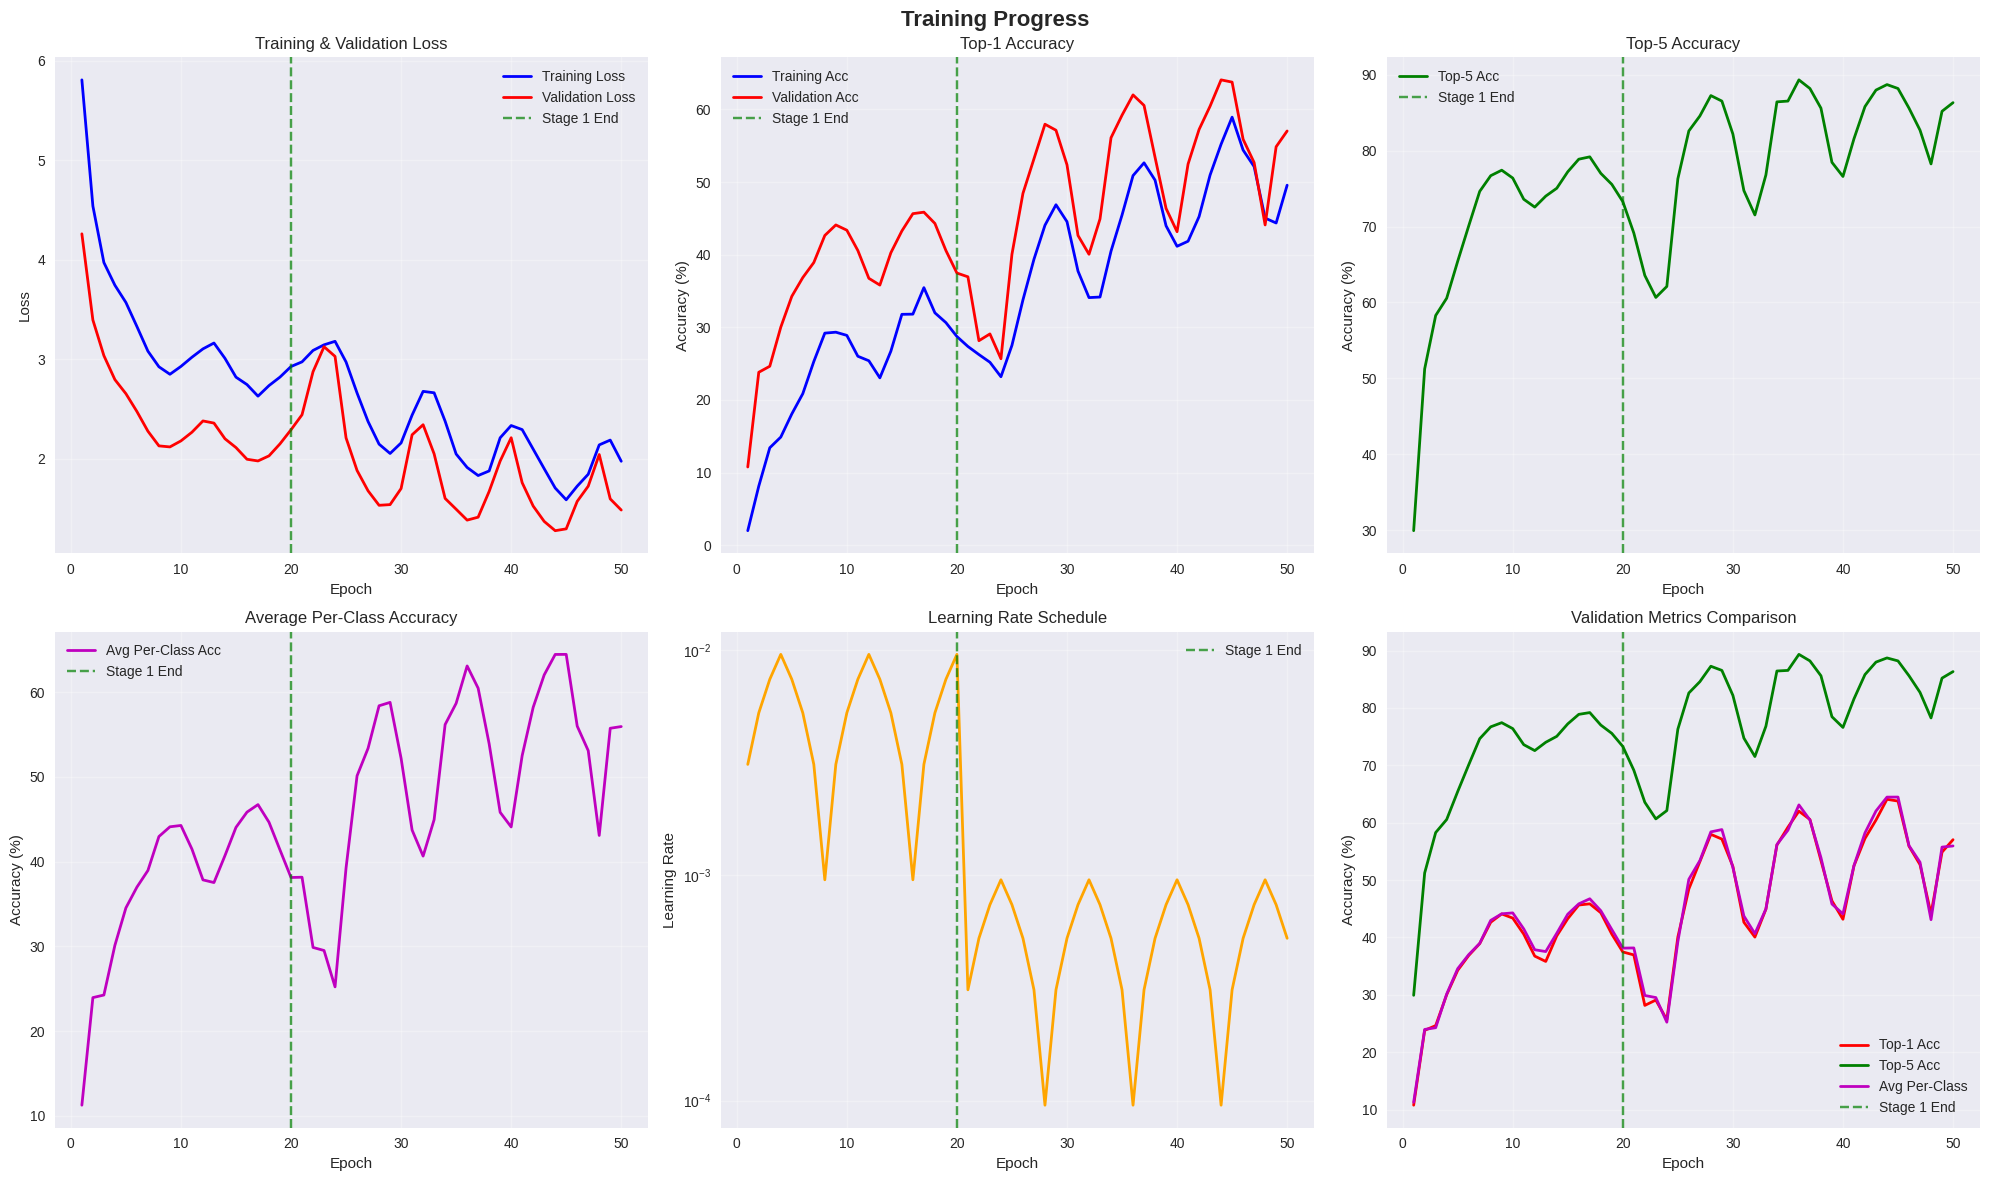

 Training curves saved: checkpoints/resnet50/resnet50_training_curves.png

 ResNet-50 training completed!
Best validation accuracy: 64.08%

Moving to next model...

 TRAINING MODEL 2/2: EFFICIENTNET-B3
 Creating datasets for EfficientNet-B3 (input size: 300x300)...
Loaded 4829 samples from train.txt
Found 200 classes
Loaded 1204 samples from test.txt
Found 200 classes
Datasets created for EfficientNet-B3!
Training samples: 3863
Validation samples: 966
Created EfficientNet-B3 model
Model architecture: EfficientNet-B3
Total parameters: 11,667,440
Trainable parameters: 11,667,440
Input size: 300x300

 Starting Two-Stage Training for EfficientNet-B3...

 STAGE 1: TRAINING EFFICIENTNET-B3 CUSTOM HEAD ONLY
 EPOCHS 1-20
ResNet50 backbone frozen (feature extraction mode)

Parameter Summary:
   Total parameters: 11,667,440
   Trainable parameters: 971,208
   Frozen parameters: 10,696,232
   Percentage trainable: 8.32%
 Created optimizer and scheduler for stage1:
   Base LR: 9.55e-04
   Max LR: 

Training Epoch 1:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 1 Summary:
   Train Loss: 5.8869 | Train Acc: 1.94%
   Val Loss: 4.3148 | Val Acc: 13.46%
   Val Top-5: 33.33% | Avg Per-Class: 13.73%
   Learning Rate: 3.10e-03
    New best validation accuracy: 13.46%

 EfficientNet-B3 - Epoch 2/20 - Stage 1
------------------------------------------------------------


Training Epoch 2:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 2 Summary:
   Train Loss: 4.5089 | Train Acc: 8.10%
   Val Loss: 3.9815 | Val Acc: 25.05%
   Val Top-5: 53.42% | Avg Per-Class: 24.92%
   Learning Rate: 5.25e-03
    New best validation accuracy: 25.05%

 EfficientNet-B3 - Epoch 3/20 - Stage 1
------------------------------------------------------------


Training Epoch 3:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 3 Summary:
   Train Loss: 3.8035 | Train Acc: 15.30%
   Val Loss: 4.4385 | Val Acc: 28.88%
   Val Top-5: 62.84% | Avg Per-Class: 28.44%
   Learning Rate: 7.40e-03
    New best validation accuracy: 28.88%

 EfficientNet-B3 - Epoch 4/20 - Stage 1
------------------------------------------------------------


Training Epoch 4:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 4 Summary:
   Train Loss: 3.5282 | Train Acc: 18.66%
   Val Loss: 2.9942 | Val Acc: 28.99%
   Val Top-5: 60.46% | Avg Per-Class: 29.69%
   Learning Rate: 9.55e-03
    New best validation accuracy: 28.99%

 EfficientNet-B3 - Epoch 5/20 - Stage 1
------------------------------------------------------------


Training Epoch 5:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 5 Summary:
   Train Loss: 3.3108 | Train Acc: 21.07%
   Val Loss: 3.9557 | Val Acc: 36.54%
   Val Top-5: 67.91% | Avg Per-Class: 37.06%
   Learning Rate: 7.40e-03
    New best validation accuracy: 36.54%
    Checkpoint saved: checkpoints/efficientnet_b3/checkpoint_stage1_epoch_5.pth

 EfficientNet-B3 - Epoch 6/20 - Stage 1
------------------------------------------------------------


Training Epoch 6:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 6 Summary:
   Train Loss: 3.0468 | Train Acc: 25.34%
   Val Loss: 3.4085 | Val Acc: 39.13%
   Val Top-5: 71.43% | Avg Per-Class: 38.52%
   Learning Rate: 5.25e-03
    New best validation accuracy: 39.13%

 EfficientNet-B3 - Epoch 7/20 - Stage 1
------------------------------------------------------------


Training Epoch 7:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 7 Summary:
   Train Loss: 2.8222 | Train Acc: 31.61%
   Val Loss: 3.9606 | Val Acc: 45.13%
   Val Top-5: 78.05% | Avg Per-Class: 46.53%
   Learning Rate: 3.10e-03
    New best validation accuracy: 45.13%

 EfficientNet-B3 - Epoch 8/20 - Stage 1
------------------------------------------------------------


Training Epoch 8:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 8 Summary:
   Train Loss: 2.6698 | Train Acc: 33.42%
   Val Loss: 2.2315 | Val Acc: 47.10%
   Val Top-5: 78.36% | Avg Per-Class: 46.54%
   Learning Rate: 9.55e-04
    New best validation accuracy: 47.10%

 EfficientNet-B3 - Epoch 9/20 - Stage 1
------------------------------------------------------------


Training Epoch 9:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 9 Summary:
   Train Loss: 2.5293 | Train Acc: 37.48%
   Val Loss: 2.9086 | Val Acc: 48.86%
   Val Top-5: 76.50% | Avg Per-Class: 48.86%
   Learning Rate: 3.10e-03
    New best validation accuracy: 48.86%

 EfficientNet-B3 - Epoch 10/20 - Stage 1
------------------------------------------------------------


Training Epoch 10:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 10 Summary:
   Train Loss: 2.5836 | Train Acc: 35.23%
   Val Loss: 3.3713 | Val Acc: 45.76%
   Val Top-5: 78.26% | Avg Per-Class: 46.04%
   Learning Rate: 5.25e-03
    Checkpoint saved: checkpoints/efficientnet_b3/checkpoint_stage1_epoch_10.pth

 EfficientNet-B3 - Epoch 11/20 - Stage 1
------------------------------------------------------------


Training Epoch 11:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 11:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 11 Summary:
   Train Loss: 2.6491 | Train Acc: 34.43%
   Val Loss: 4.1661 | Val Acc: 44.62%
   Val Top-5: 76.50% | Avg Per-Class: 45.74%
   Learning Rate: 7.40e-03

 EfficientNet-B3 - Epoch 12/20 - Stage 1
------------------------------------------------------------


Training Epoch 12:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 12:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 12 Summary:
   Train Loss: 2.8747 | Train Acc: 30.75%
   Val Loss: 3.2981 | Val Acc: 39.75%
   Val Top-5: 75.16% | Avg Per-Class: 41.14%
   Learning Rate: 9.55e-03

 EfficientNet-B3 - Epoch 13/20 - Stage 1
------------------------------------------------------------


Training Epoch 13:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 13:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 13 Summary:
   Train Loss: 2.8403 | Train Acc: 30.31%
   Val Loss: 4.0253 | Val Acc: 43.79%
   Val Top-5: 76.09% | Avg Per-Class: 43.14%
   Learning Rate: 7.40e-03

 EfficientNet-B3 - Epoch 14/20 - Stage 1
------------------------------------------------------------


Training Epoch 14:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 14:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 14 Summary:
   Train Loss: 2.6989 | Train Acc: 33.21%
   Val Loss: 2.2003 | Val Acc: 45.96%
   Val Top-5: 77.12% | Avg Per-Class: 45.65%
   Learning Rate: 5.25e-03

 EfficientNet-B3 - Epoch 15/20 - Stage 1
------------------------------------------------------------


Training Epoch 15:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 15:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 15 Summary:
   Train Loss: 2.5308 | Train Acc: 37.30%
   Val Loss: 2.5236 | Val Acc: 50.10%
   Val Top-5: 81.68% | Avg Per-Class: 50.53%
   Learning Rate: 3.10e-03
    New best validation accuracy: 50.10%
    Checkpoint saved: checkpoints/efficientnet_b3/checkpoint_stage1_epoch_15.pth

 EfficientNet-B3 - Epoch 16/20 - Stage 1
------------------------------------------------------------


Training Epoch 16:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 16:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 16 Summary:
   Train Loss: 2.3303 | Train Acc: 40.67%
   Val Loss: 1.9393 | Val Acc: 52.48%
   Val Top-5: 82.19% | Avg Per-Class: 52.44%
   Learning Rate: 9.55e-04
    New best validation accuracy: 52.48%

 EfficientNet-B3 - Epoch 17/20 - Stage 1
------------------------------------------------------------


Training Epoch 17:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 17:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 17 Summary:
   Train Loss: 2.3125 | Train Acc: 41.08%
   Val Loss: 1.9738 | Val Acc: 51.66%
   Val Top-5: 81.16% | Avg Per-Class: 51.80%
   Learning Rate: 3.10e-03

 EfficientNet-B3 - Epoch 18/20 - Stage 1
------------------------------------------------------------


Training Epoch 18:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 18:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 18 Summary:
   Train Loss: 2.3204 | Train Acc: 41.55%
   Val Loss: 5.4940 | Val Acc: 50.93%
   Val Top-5: 80.23% | Avg Per-Class: 50.36%
   Learning Rate: 5.25e-03

 EfficientNet-B3 - Epoch 19/20 - Stage 1
------------------------------------------------------------


Training Epoch 19:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 19:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 19 Summary:
   Train Loss: 2.4460 | Train Acc: 38.42%
   Val Loss: 2.1005 | Val Acc: 45.55%
   Val Top-5: 78.57% | Avg Per-Class: 45.96%
   Learning Rate: 7.40e-03

 EfficientNet-B3 - Epoch 20/20 - Stage 1
------------------------------------------------------------


Training Epoch 20:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 20:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 20 Summary:
   Train Loss: 2.6532 | Train Acc: 33.55%
   Val Loss: 3.2447 | Val Acc: 45.45%
   Val Top-5: 78.47% | Avg Per-Class: 45.32%
   Learning Rate: 9.55e-03
    Checkpoint saved: checkpoints/efficientnet_b3/checkpoint_stage1_epoch_20.pth

 EfficientNet-B3 Stage 1 completed! Best validation accuracy: 52.48%

STAGE 2: FINE-TUNING EFFICIENTNET-B3 WITH UNFREEZING
EPOCHS 21-50

Parameter Summary:
   Total parameters: 11,667,440
   Trainable parameters: 10,272,150
   Frozen parameters: 1,395,290
   Percentage trainable: 88.04%
 Created optimizer and scheduler for stage2:
   Base LR: 9.55e-05
   Max LR: 9.55e-04
   Step size up: 484 iterations (4 epochs)

EfficientNet-B3 - Epoch 21/50 - Stage 2
------------------------------------------------------------


Training Epoch 21:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 21:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 21 Summary:
   Train Loss: 2.3333 | Train Acc: 40.56%
   Val Loss: 2.0351 | Val Acc: 55.59%
   Val Top-5: 85.09% | Avg Per-Class: 56.27%
   Learning Rate: 3.10e-04
    New best validation accuracy: 55.59%

EfficientNet-B3 - Epoch 22/50 - Stage 2
------------------------------------------------------------


Training Epoch 22:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 22:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 22 Summary:
   Train Loss: 2.0789 | Train Acc: 46.39%
   Val Loss: 1.9492 | Val Acc: 61.49%
   Val Top-5: 86.44% | Avg Per-Class: 60.24%
   Learning Rate: 5.25e-04
    New best validation accuracy: 61.49%

EfficientNet-B3 - Epoch 23/50 - Stage 2
------------------------------------------------------------


Training Epoch 23:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 23:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 23 Summary:
   Train Loss: 1.9630 | Train Acc: 48.28%
   Val Loss: 1.6005 | Val Acc: 59.32%
   Val Top-5: 85.92% | Avg Per-Class: 58.67%
   Learning Rate: 7.40e-04

EfficientNet-B3 - Epoch 24/50 - Stage 2
------------------------------------------------------------


Training Epoch 24:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 24:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 24 Summary:
   Train Loss: 1.8682 | Train Acc: 52.37%
   Val Loss: 1.5078 | Val Acc: 58.59%
   Val Top-5: 85.82% | Avg Per-Class: 58.02%
   Learning Rate: 9.55e-04

EfficientNet-B3 - Epoch 25/50 - Stage 2
------------------------------------------------------------


Training Epoch 25:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 25:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 25 Summary:
   Train Loss: 1.8451 | Train Acc: 52.01%
   Val Loss: 1.4370 | Val Acc: 61.18%
   Val Top-5: 85.40% | Avg Per-Class: 60.69%
   Learning Rate: 7.40e-04
   Checkpoint saved: checkpoints/efficientnet_b3/checkpoint_stage2_epoch_25.pth

EfficientNet-B3 - Epoch 26/50 - Stage 2
------------------------------------------------------------


Training Epoch 26:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 26:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 26 Summary:
   Train Loss: 1.6560 | Train Acc: 56.51%
   Val Loss: 1.2563 | Val Acc: 66.98%
   Val Top-5: 89.13% | Avg Per-Class: 67.32%
   Learning Rate: 5.25e-04
    New best validation accuracy: 66.98%

EfficientNet-B3 - Epoch 27/50 - Stage 2
------------------------------------------------------------


Training Epoch 27:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 27:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 27 Summary:
   Train Loss: 1.4731 | Train Acc: 60.99%
   Val Loss: 1.2942 | Val Acc: 66.15%
   Val Top-5: 88.72% | Avg Per-Class: 65.22%
   Learning Rate: 3.10e-04

EfficientNet-B3 - Epoch 28/50 - Stage 2
------------------------------------------------------------


Training Epoch 28:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 28:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 28 Summary:
   Train Loss: 1.3433 | Train Acc: 64.41%
   Val Loss: 1.1429 | Val Acc: 68.32%
   Val Top-5: 89.96% | Avg Per-Class: 68.95%
   Learning Rate: 9.55e-05
    New best validation accuracy: 68.32%

EfficientNet-B3 - Epoch 29/50 - Stage 2
------------------------------------------------------------


Training Epoch 29:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 29:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 29 Summary:
   Train Loss: 1.2077 | Train Acc: 68.42%
   Val Loss: 1.0762 | Val Acc: 70.60%
   Val Top-5: 90.89% | Avg Per-Class: 69.82%
   Learning Rate: 3.10e-04
    New best validation accuracy: 70.60%

EfficientNet-B3 - Epoch 30/50 - Stage 2
------------------------------------------------------------


Training Epoch 30:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 30:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 30 Summary:
   Train Loss: 1.2208 | Train Acc: 67.77%
   Val Loss: 1.1660 | Val Acc: 68.84%
   Val Top-5: 89.44% | Avg Per-Class: 68.70%
   Learning Rate: 5.25e-04
   Checkpoint saved: checkpoints/efficientnet_b3/checkpoint_stage2_epoch_30.pth

EfficientNet-B3 - Epoch 31/50 - Stage 2
------------------------------------------------------------


Training Epoch 31:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 31:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 31 Summary:
   Train Loss: 1.2918 | Train Acc: 66.76%
   Val Loss: 1.3387 | Val Acc: 65.63%
   Val Top-5: 88.61% | Avg Per-Class: 65.93%
   Learning Rate: 7.40e-04

EfficientNet-B3 - Epoch 32/50 - Stage 2
------------------------------------------------------------


Training Epoch 32:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 32:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 32 Summary:
   Train Loss: 1.4962 | Train Acc: 61.71%
   Val Loss: 1.7922 | Val Acc: 58.49%
   Val Top-5: 84.58% | Avg Per-Class: 58.40%
   Learning Rate: 9.55e-04

EfficientNet-B3 - Epoch 33/50 - Stage 2
------------------------------------------------------------


Training Epoch 33:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 33:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 33 Summary:
   Train Loss: 1.4965 | Train Acc: 60.39%
   Val Loss: 1.2855 | Val Acc: 64.60%
   Val Top-5: 87.68% | Avg Per-Class: 65.32%
   Learning Rate: 7.40e-04

EfficientNet-B3 - Epoch 34/50 - Stage 2
------------------------------------------------------------


Training Epoch 34:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 34:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 34 Summary:
   Train Loss: 1.3925 | Train Acc: 64.04%
   Val Loss: 1.4972 | Val Acc: 68.12%
   Val Top-5: 89.13% | Avg Per-Class: 66.98%
   Learning Rate: 5.25e-04

EfficientNet-B3 - Epoch 35/50 - Stage 2
------------------------------------------------------------


Training Epoch 35:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 35:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 35 Summary:
   Train Loss: 1.1438 | Train Acc: 70.46%
   Val Loss: 1.4558 | Val Acc: 70.08%
   Val Top-5: 90.17% | Avg Per-Class: 69.61%
   Learning Rate: 3.10e-04
   Checkpoint saved: checkpoints/efficientnet_b3/checkpoint_stage2_epoch_35.pth

EfficientNet-B3 - Epoch 36/50 - Stage 2
------------------------------------------------------------


Training Epoch 36:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 36:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 36 Summary:
   Train Loss: 1.0540 | Train Acc: 72.97%
   Val Loss: 1.4119 | Val Acc: 71.95%
   Val Top-5: 90.89% | Avg Per-Class: 70.70%
   Learning Rate: 9.55e-05
    New best validation accuracy: 71.95%

EfficientNet-B3 - Epoch 37/50 - Stage 2
------------------------------------------------------------


Training Epoch 37:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 37:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 37 Summary:
   Train Loss: 1.0120 | Train Acc: 74.06%
   Val Loss: 1.3181 | Val Acc: 70.50%
   Val Top-5: 91.30% | Avg Per-Class: 69.62%
   Learning Rate: 3.10e-04

EfficientNet-B3 - Epoch 38/50 - Stage 2
------------------------------------------------------------


Training Epoch 38:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 38:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 38 Summary:
   Train Loss: 1.0272 | Train Acc: 74.06%
   Val Loss: 1.0637 | Val Acc: 71.64%
   Val Top-5: 90.48% | Avg Per-Class: 71.29%
   Learning Rate: 5.25e-04

EfficientNet-B3 - Epoch 39/50 - Stage 2
------------------------------------------------------------


Training Epoch 39:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 39:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 39 Summary:
   Train Loss: 1.0655 | Train Acc: 72.79%
   Val Loss: 1.2944 | Val Acc: 67.91%
   Val Top-5: 89.03% | Avg Per-Class: 67.57%
   Learning Rate: 7.40e-04

EfficientNet-B3 - Epoch 40/50 - Stage 2
------------------------------------------------------------


Training Epoch 40:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 40:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 40 Summary:
   Train Loss: 1.2739 | Train Acc: 67.67%
   Val Loss: 2.3287 | Val Acc: 63.46%
   Val Top-5: 84.68% | Avg Per-Class: 63.94%
   Learning Rate: 9.55e-04
   Checkpoint saved: checkpoints/efficientnet_b3/checkpoint_stage2_epoch_40.pth

EfficientNet-B3 - Epoch 41/50 - Stage 2
------------------------------------------------------------


Training Epoch 41:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 41:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 41 Summary:
   Train Loss: 1.3536 | Train Acc: 64.66%
   Val Loss: 1.4685 | Val Acc: 63.56%
   Val Top-5: 86.02% | Avg Per-Class: 63.46%
   Learning Rate: 7.40e-04

EfficientNet-B3 - Epoch 42/50 - Stage 2
------------------------------------------------------------


Training Epoch 42:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 42:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 42 Summary:
   Train Loss: 1.1594 | Train Acc: 69.74%
   Val Loss: 1.3028 | Val Acc: 69.25%
   Val Top-5: 88.72% | Avg Per-Class: 69.38%
   Learning Rate: 5.25e-04

EfficientNet-B3 - Epoch 43/50 - Stage 2
------------------------------------------------------------


Training Epoch 43:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 43:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 43 Summary:
   Train Loss: 1.0242 | Train Acc: 74.22%
   Val Loss: 1.0801 | Val Acc: 71.84%
   Val Top-5: 90.99% | Avg Per-Class: 71.68%
   Learning Rate: 3.10e-04

EfficientNet-B3 - Epoch 44/50 - Stage 2
------------------------------------------------------------


Training Epoch 44:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 44:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 44 Summary:
   Train Loss: 0.9234 | Train Acc: 77.09%
   Val Loss: 1.0237 | Val Acc: 73.40%
   Val Top-5: 91.30% | Avg Per-Class: 73.44%
   Learning Rate: 9.55e-05
    New best validation accuracy: 73.40%

EfficientNet-B3 - Epoch 45/50 - Stage 2
------------------------------------------------------------


Training Epoch 45:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 45:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 45 Summary:
   Train Loss: 0.8569 | Train Acc: 78.46%
   Val Loss: 1.2061 | Val Acc: 71.53%
   Val Top-5: 90.48% | Avg Per-Class: 70.91%
   Learning Rate: 3.10e-04
   Checkpoint saved: checkpoints/efficientnet_b3/checkpoint_stage2_epoch_45.pth

EfficientNet-B3 - Epoch 46/50 - Stage 2
------------------------------------------------------------


Training Epoch 46:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 46:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 46 Summary:
   Train Loss: 0.8639 | Train Acc: 78.75%
   Val Loss: 1.3204 | Val Acc: 71.53%
   Val Top-5: 89.75% | Avg Per-Class: 71.10%
   Learning Rate: 5.25e-04

EfficientNet-B3 - Epoch 47/50 - Stage 2
------------------------------------------------------------


Training Epoch 47:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 47:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 47 Summary:
   Train Loss: 0.9150 | Train Acc: 77.45%
   Val Loss: 1.3781 | Val Acc: 67.39%
   Val Top-5: 89.65% | Avg Per-Class: 67.67%
   Learning Rate: 7.40e-04

EfficientNet-B3 - Epoch 48/50 - Stage 2
------------------------------------------------------------


Training Epoch 48:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 48:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 48 Summary:
   Train Loss: 1.1167 | Train Acc: 72.04%
   Val Loss: 1.3400 | Val Acc: 66.15%
   Val Top-5: 88.41% | Avg Per-Class: 65.82%
   Learning Rate: 9.55e-04

EfficientNet-B3 - Epoch 49/50 - Stage 2
------------------------------------------------------------


Training Epoch 49:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 49:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 49 Summary:
   Train Loss: 1.1748 | Train Acc: 69.35%
   Val Loss: 1.3412 | Val Acc: 65.63%
   Val Top-5: 87.68% | Avg Per-Class: 65.59%
   Learning Rate: 7.40e-04

EfficientNet-B3 - Epoch 50/50 - Stage 2
------------------------------------------------------------


Training Epoch 50:   0%|          | 0/121 [00:00<?, ?it/s]

Validation Epoch 50:   0%|          | 0/31 [00:00<?, ?it/s]


 EfficientNet-B3 - Epoch 50 Summary:
   Train Loss: 1.0582 | Train Acc: 73.00%
   Val Loss: 1.1812 | Val Acc: 69.15%
   Val Top-5: 90.89% | Avg Per-Class: 68.70%
   Learning Rate: 5.25e-04
   Checkpoint saved: checkpoints/efficientnet_b3/checkpoint_stage2_epoch_50.pth

 Loaded best EfficientNet-B3 model with validation accuracy: 73.40%
 Best EfficientNet-B3 model saved: checkpoints/efficientnet_b3/best_model.pth
 Model metadata saved: checkpoints/efficientnet_b3/model_metadata.json

 Plotting EfficientNet-B3 training curves...


<Figure size 800x550 with 0 Axes>

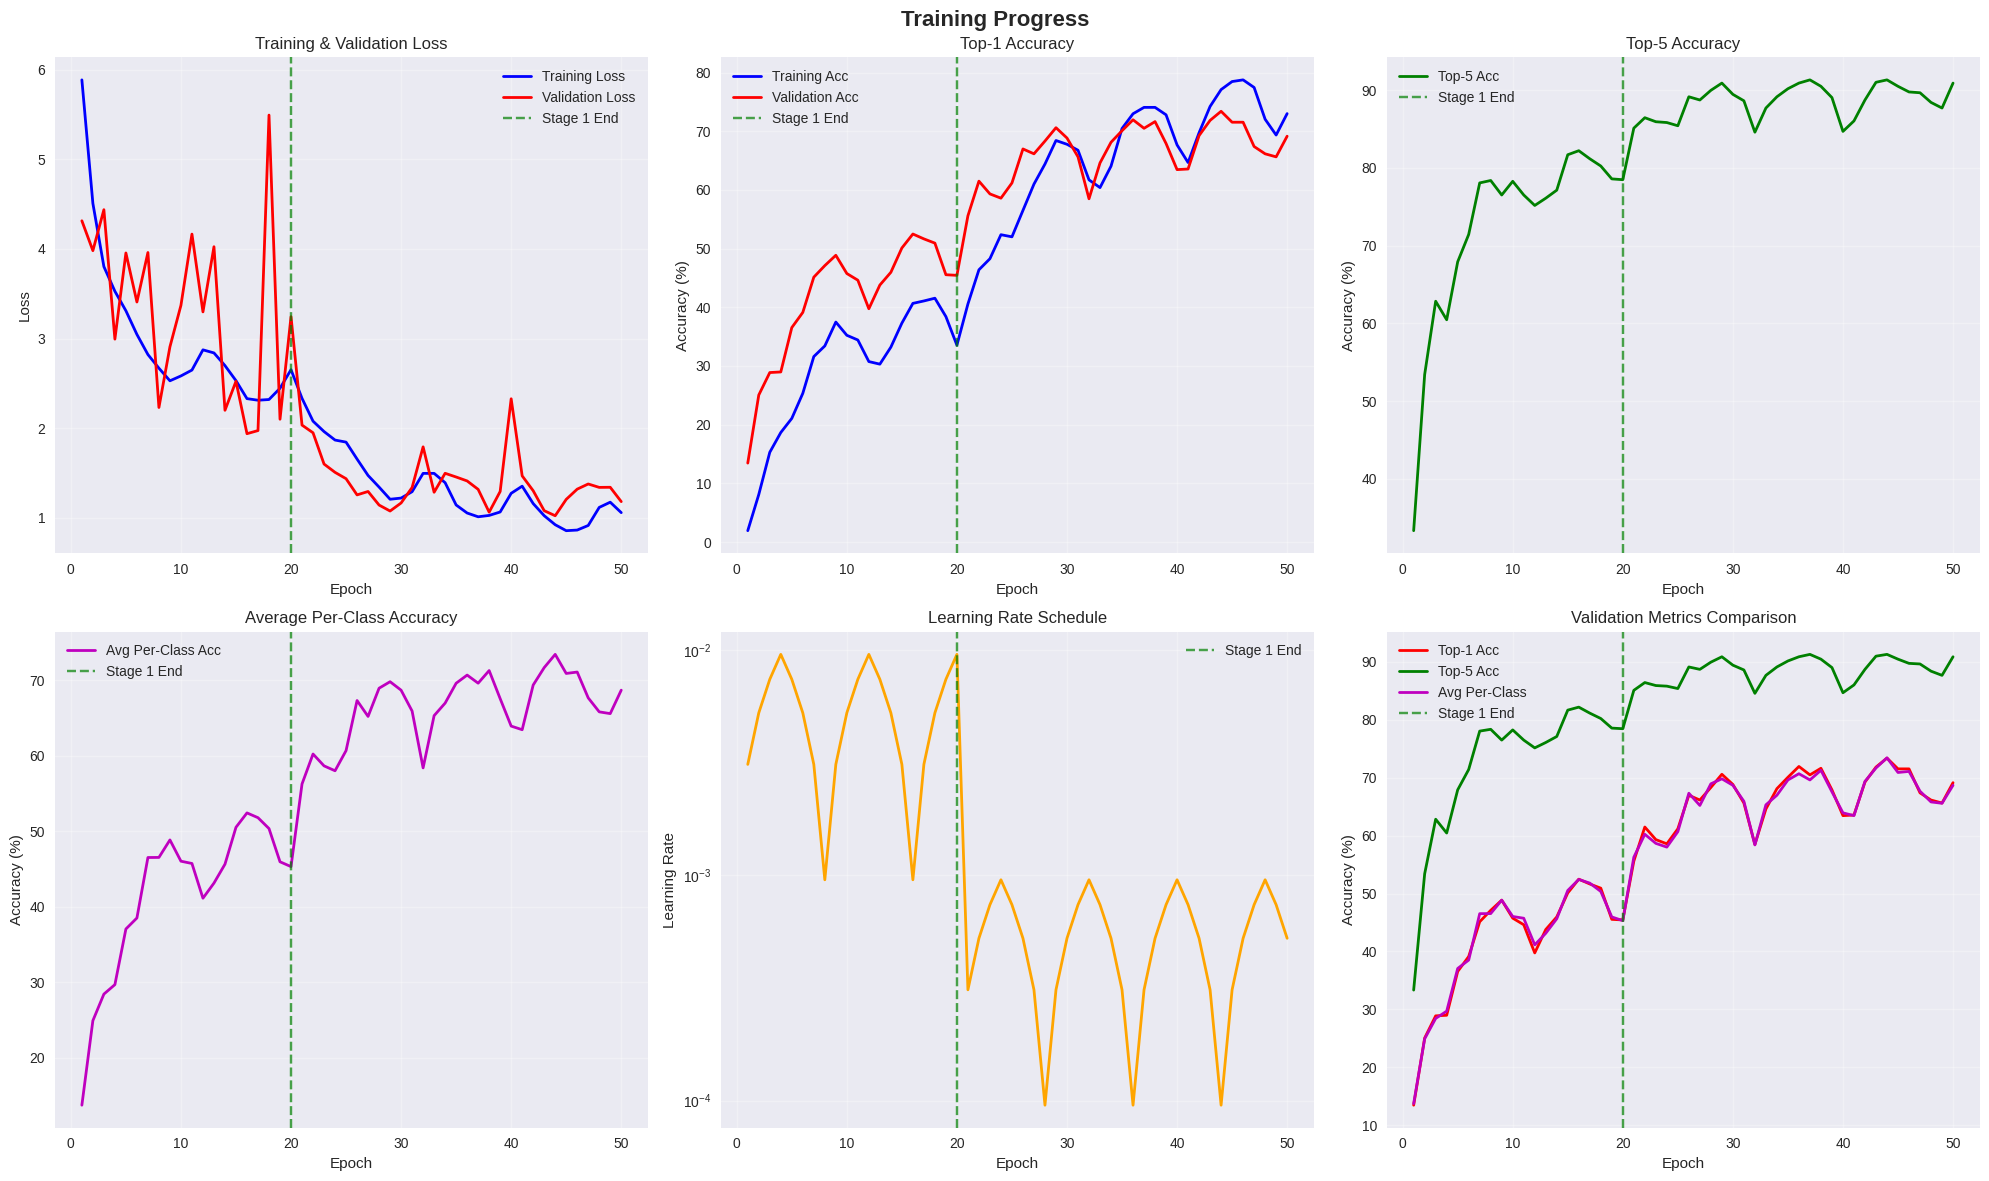

 Training curves saved: checkpoints/efficientnet_b3/efficientnet_b3_training_curves.png

 EfficientNet-B3 training completed!
Best validation accuracy: 73.40%
FINAL TRAINING RESULTS
ResNet-50: 64.08% validation accuracy
EfficientNet-B3: 73.40% validation accuracy

Best performing model: EfficientNet-B3 (73.40%)

 All models training completed!
Final Results Summary:
   ResNet-50: 64.08% validation accuracy
   EfficientNet-B3: 73.40% validation accuracy


<Figure size 800x550 with 0 Axes>

In [44]:
# Run training for all models
print("Starting multi-model training session...")

# Execute training
results = train_all_models()

print("\n All models training completed!")
print("Final Results Summary:")
for model_name, accuracy in results.items():
    model_config = Config.get_model_config(model_name)
    print(f"   {model_config['name']}: {accuracy:.2f}% validation accuracy")

## 22. Evaluation on Test Set

This section provides complete evaluation of the trained model:
- Test set evaluation with all required metrics
- Per-class accuracy analysis
- Confusion matrix for difficult species
- Sample predictions visualization
- Model performance analysis

In [45]:
def evaluate_on_test_set(device=Config.DEVICE):
    """
    Evaluation on test set for all trained models.
    Creates model-specific test loaders for fair evaluation.
    """
    all_model_results = {}

    for model_name in Config.MODELS_TO_TRAIN:
        model_config = Config.get_model_config(model_name)
        checkpoint_dir = Config.get_checkpoints_dir(model_name)
        best_model_path = checkpoint_dir / "best_model.pth"

        print(f"\n Evaluating {model_config['name']} on test set...")

        if not best_model_path.exists():
            print(f"Best model checkpoint not found for {model_config['name']}, skipping evaluation.")
            all_model_results[model_name] = None
            continue

        # Create model-specific test loader with correct transforms
        test_transforms = model_transforms[model_name]['val']
        model_test_dataset = CUBDataset(
            annotations_file=Config.TEST_ANNOTATIONS,
            img_dir=Config.TEST_DIR,
            transform=test_transforms
        )

        model_test_loader = DataLoader(
            model_test_dataset,
            batch_size=Config.BATCH_SIZE,
            shuffle=False,
            num_workers=0 if 'google.colab' in str(get_ipython()) else 4,
            pin_memory=True
        )

        # Load the model
        try:
            checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
            if model_name == 'resnet50':
                model = BirdClassifier(num_classes=Config.NUM_CLASSES)
            elif model_name == 'efficientnet_b3':
                model = EfficientNetB3Classifier(num_classes=Config.NUM_CLASSES)
            else:
                print(f"Unknown model type {model_name}, skipping.")
                all_model_results[model_name] = None
                continue

            model.load_state_dict(checkpoint['model_state_dict'])
            model = model.to(device)
            print(f"Best {model_config['name']} model loaded (validation accuracy: {checkpoint['best_val_acc']:.2f}%)")
        except Exception as e:
            print(f"Error loading model {model_config['name']}: {e}")
            all_model_results[model_name] = None
            continue

        # Evaluate the model
        model.eval()
        criterion = nn.CrossEntropyLoss()

        all_preds = []
        all_targets = []
        all_outputs = []
        all_probs = []
        test_loss = 0.0

        with torch.no_grad():
            pbar = tqdm(model_test_loader, desc=f'{model_config["name"]} Test Evaluation')

            for batch_idx, (data, targets) in enumerate(pbar):
                data, targets = data.to(device), targets.to(device)

                outputs = model(data)
                loss = criterion(outputs, targets)

                probs = F.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)

                test_loss += loss.item()
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                all_outputs.extend(outputs.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

                pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        # Calculate metrics
        avg_test_loss = test_loss / len(model_test_loader)
        top1_acc = accuracy_score(all_targets, all_preds) * 100

        all_outputs_tensor = torch.tensor(all_outputs)
        all_targets_tensor = torch.tensor(all_targets)
        top5_acc = calculate_top_k_accuracy(all_outputs_tensor, all_targets_tensor, k=5)

        per_class_acc_dict, avg_per_class_acc = calculate_per_class_accuracy(
            all_preds, all_targets, Config.NUM_CLASSES
        )

        model_results = {
            'test_loss': avg_test_loss,
            'top1_accuracy': top1_acc,
            'top5_accuracy': top5_acc,
            'avg_per_class_accuracy': avg_per_class_acc * 100,
            'per_class_accuracy': per_class_acc_dict,
            'total_samples': len(all_targets),
            'predictions': all_preds,
            'targets': all_targets,
            'outputs': all_outputs,
            'probabilities': all_probs
        }
        all_model_results[model_name] = model_results

        print(f"\n{model_config['name']} TEST SET RESULTS:")
        print("=" * 50)
        print(f"Test Loss: {avg_test_loss:.4f}")
        print(f"Top-1 Accuracy: {top1_acc:.2f}%")
        print(f"Top-5 Accuracy: {top5_acc:.2f}%")
        print(f"Average Per-Class Accuracy: {avg_per_class_acc * 100:.2f}%")
        print(f"Total Test Samples: {len(all_targets)}")

        del model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return all_model_results

# Evaluate on test set for all models
test_results_all_models = evaluate_on_test_set()

print(f"\n EVALUATION COMPLETE!")
print(f"Successfully evaluated {len([k for k, v in test_results_all_models.items() if v is not None])} models")


 Evaluating ResNet-50 on test set...
Loaded 1204 samples from test.txt
Found 200 classes
Best ResNet-50 model loaded (validation accuracy: 64.08%)


ResNet-50 Test Evaluation:   0%|          | 0/38 [00:00<?, ?it/s]


ResNet-50 TEST SET RESULTS:
Test Loss: 1.2325
Top-1 Accuracy: 67.19%
Top-5 Accuracy: 90.70%
Average Per-Class Accuracy: 65.95%
Total Test Samples: 1204

 Evaluating EfficientNet-B3 on test set...
Loaded 1204 samples from test.txt
Found 200 classes
Best EfficientNet-B3 model loaded (validation accuracy: 73.40%)


EfficientNet-B3 Test Evaluation:   0%|          | 0/38 [00:00<?, ?it/s]


EfficientNet-B3 TEST SET RESULTS:
Test Loss: 1.1934
Top-1 Accuracy: 72.76%
Top-5 Accuracy: 91.53%
Average Per-Class Accuracy: 72.24%
Total Test Samples: 1204

 EVALUATION COMPLETE!
Successfully evaluated 2 models


## 23. Per-Class Accuracy Analysis


 PER-CLASS ANALYSIS FOR RESNET-50

 TOP 10 BEST PERFORMING CLASSES:
------------------------------------------------------------
Class   3: 100.00% - Bird_Species_003
Class   2: 100.00% - Bird_Species_002
Class  52: 100.00% - Bird_Species_052
Class  49: 100.00% - Bird_Species_049
Class  66: 100.00% - Bird_Species_066
Class  68: 100.00% - Bird_Species_068
Class  69: 100.00% - Bird_Species_069
Class  11: 100.00% - Bird_Species_011
Class  56: 100.00% - Bird_Species_056
Class  45: 100.00% - Bird_Species_045

 TOP 10 WORST PERFORMING CLASSES:
------------------------------------------------------------
Class  38:  16.67% - Bird_Species_038
Class 101:  14.29% - Bird_Species_101
Class  61:   0.00% - Bird_Species_061
Class  16:   0.00% - Bird_Species_016
Class 111:   0.00% - Bird_Species_111
Class  90:   0.00% - Bird_Species_090
Class 140:   0.00% - Bird_Species_140
Class 144:   0.00% - Bird_Species_144
Class 170:   0.00% - Bird_Species_170
Class 195:   0.00% - Bird_Species_195


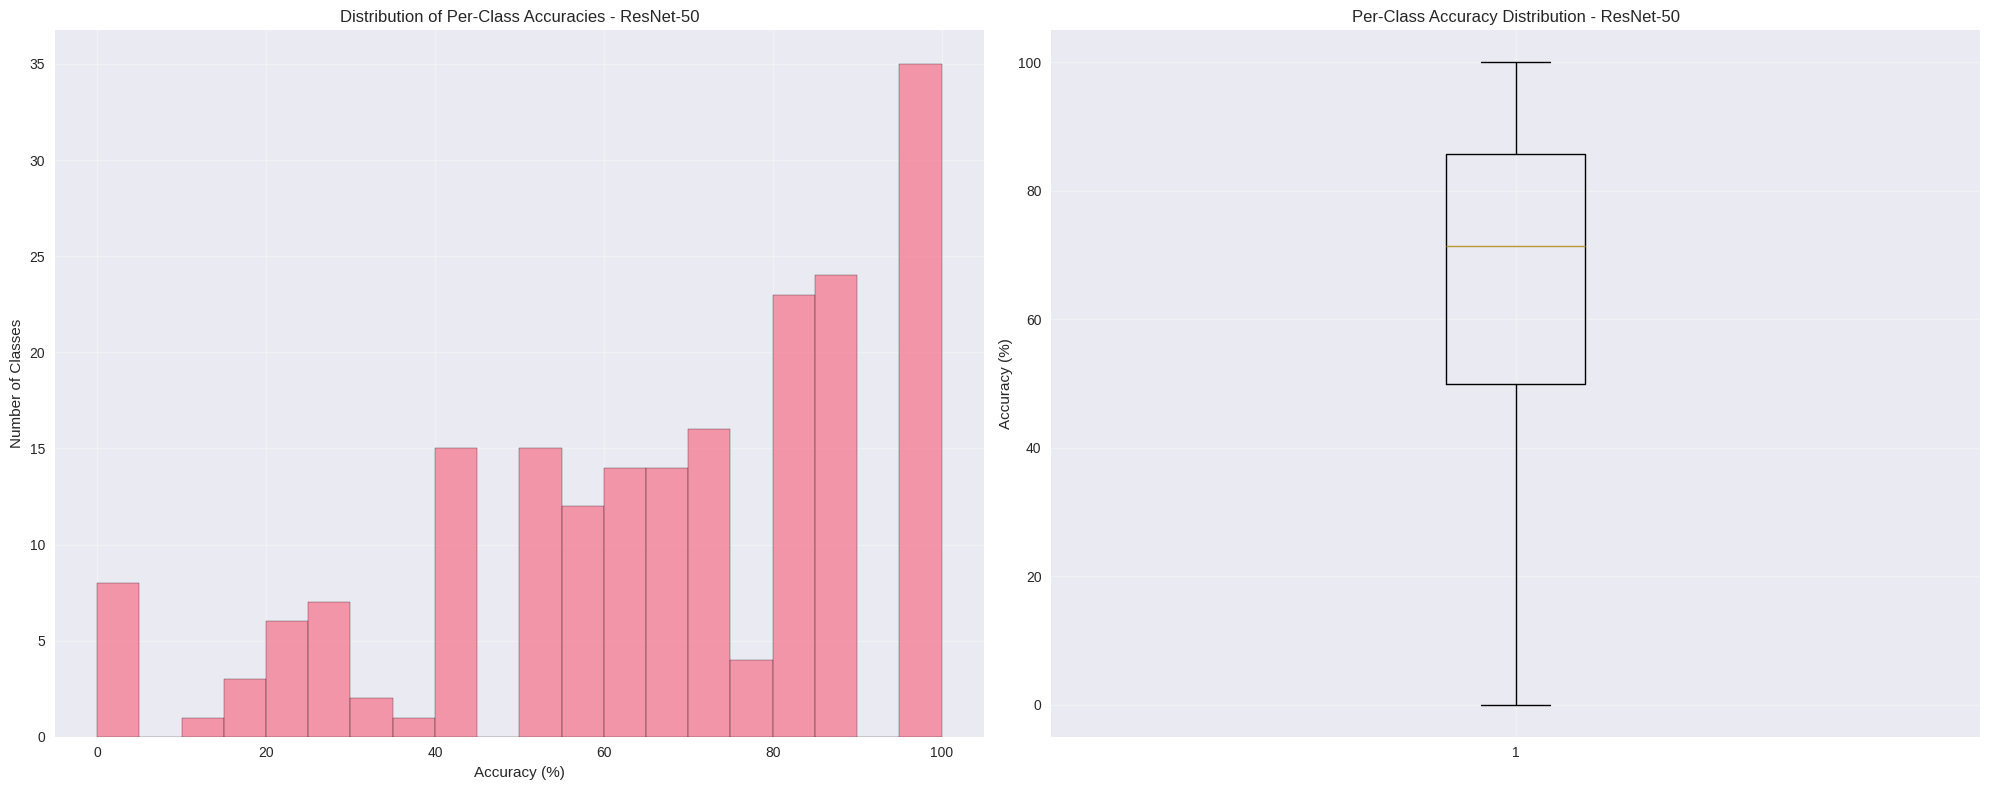


 PER-CLASS ACCURACY STATISTICS:
   Mean: 65.95%
   Median: 71.43%
   Std Dev: 26.78%
   Min: 0.00%
   Max: 100.00%

 PER-CLASS ANALYSIS FOR EFFICIENTNET-B3

 TOP 10 BEST PERFORMING CLASSES:
------------------------------------------------------------
Class   3: 100.00% - Bird_Species_003
Class   2: 100.00% - Bird_Species_002
Class   7: 100.00% - Bird_Species_007
Class   5: 100.00% - Bird_Species_005
Class  26: 100.00% - Bird_Species_026
Class  18: 100.00% - Bird_Species_018
Class  12: 100.00% - Bird_Species_012
Class  13: 100.00% - Bird_Species_013
Class  49: 100.00% - Bird_Species_049
Class  52: 100.00% - Bird_Species_052

 TOP 10 WORST PERFORMING CLASSES:
------------------------------------------------------------
Class 101:  28.57% - Bird_Species_101
Class 126:  28.57% - Bird_Species_126
Class 140:  28.57% - Bird_Species_140
Class 181:  25.00% - Bird_Species_181
Class 170:  25.00% - Bird_Species_170
Class  28:  20.00% - Bird_Species_028
Class 127:  20.00% - Bird_Species_127
Class 

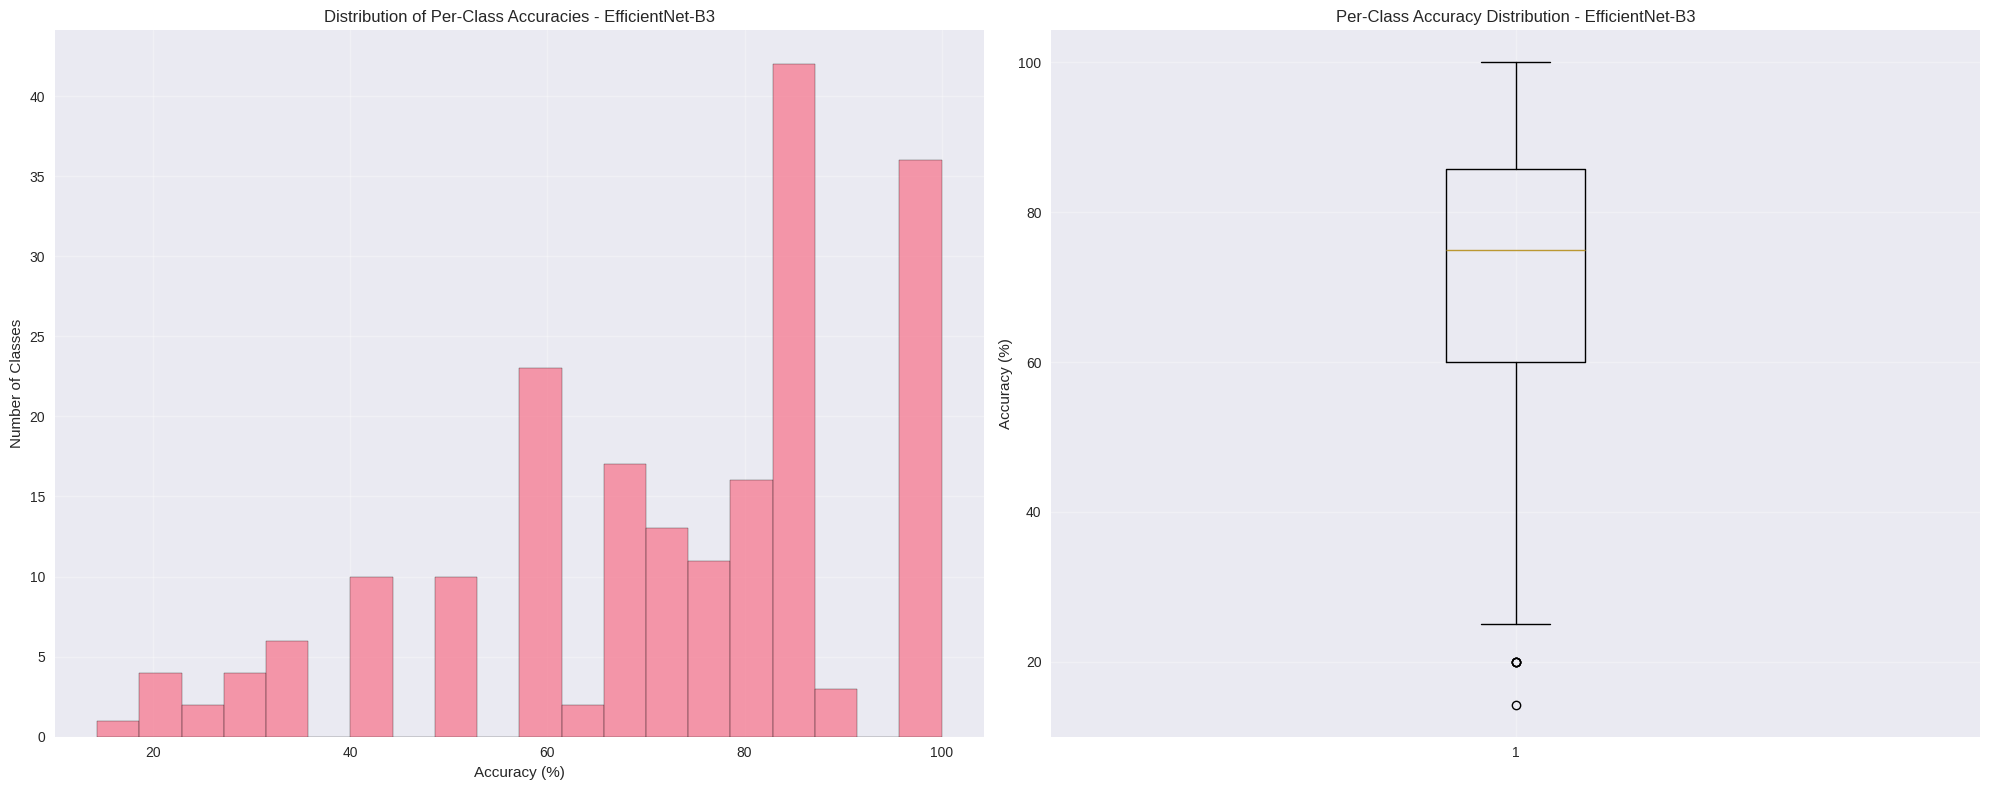


 PER-CLASS ACCURACY STATISTICS:
   Mean: 72.24%
   Median: 75.00%
   Std Dev: 21.39%
   Min: 14.29%
   Max: 100.00%


In [46]:
def analyze_per_class_performance_all_models(test_results_all_models, top_k=10):
    """
    Analyze per-class performance for all models.
    """
    for model_name, test_results in test_results_all_models.items():
        if test_results is None:
            continue

        model_config = Config.get_model_config(model_name)
        print(f"\n PER-CLASS ANALYSIS FOR {model_config['name'].upper()}")
        print("="*70)

        per_class_acc = test_results['per_class_accuracy']

        class_performance = []
        for class_id, accuracy in per_class_acc.items():
            class_performance.append({
                'class_id': class_id,
                'accuracy': accuracy * 100,
                'class_name': f'Bird_Species_{class_id:03d}'
            })

        df = pd.DataFrame(class_performance)
        df = df.sort_values('accuracy', ascending=False)

        best_classes = df.head(top_k)
        worst_classes = df.tail(top_k)

        print(f"\n TOP {top_k} BEST PERFORMING CLASSES:")
        print("-" * 60)
        for _, row in best_classes.iterrows():
            print(f"Class {row['class_id']:3d}: {row['accuracy']:6.2f}% - {row['class_name']}")

        print(f"\n TOP {top_k} WORST PERFORMING CLASSES:")
        print("-" * 60)
        for _, row in worst_classes.iterrows():
            print(f"Class {row['class_id']:3d}: {row['accuracy']:6.2f}% - {row['class_name']}")

        # Plot per-class accuracy distribution
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Histogram of accuracies
        ax1.hist(df['accuracy'], bins=20, edgecolor='black', alpha=0.7)
        ax1.set_xlabel('Accuracy (%)')
        ax1.set_ylabel('Number of Classes')
        ax1.set_title(f'Distribution of Per-Class Accuracies - {model_config["name"]}')
        ax1.grid(True, alpha=0.3)

        # Box plot
        ax2.boxplot(df['accuracy'])
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title(f'Per-Class Accuracy Distribution - {model_config["name"]}')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'per_class_accuracy_analysis_{model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n PER-CLASS ACCURACY STATISTICS:")
        print(f"   Mean: {df['accuracy'].mean():.2f}%")
        print(f"   Median: {df['accuracy'].median():.2f}%")
        print(f"   Std Dev: {df['accuracy'].std():.2f}%")
        print(f"   Min: {df['accuracy'].min():.2f}%")
        print(f"   Max: {df['accuracy'].max():.2f}%")

# Analyze all models
analyze_per_class_performance_all_models(test_results_all_models)

## 24. Confusion Matrix Visualization


 Generating confusion matrix for ResNet-50


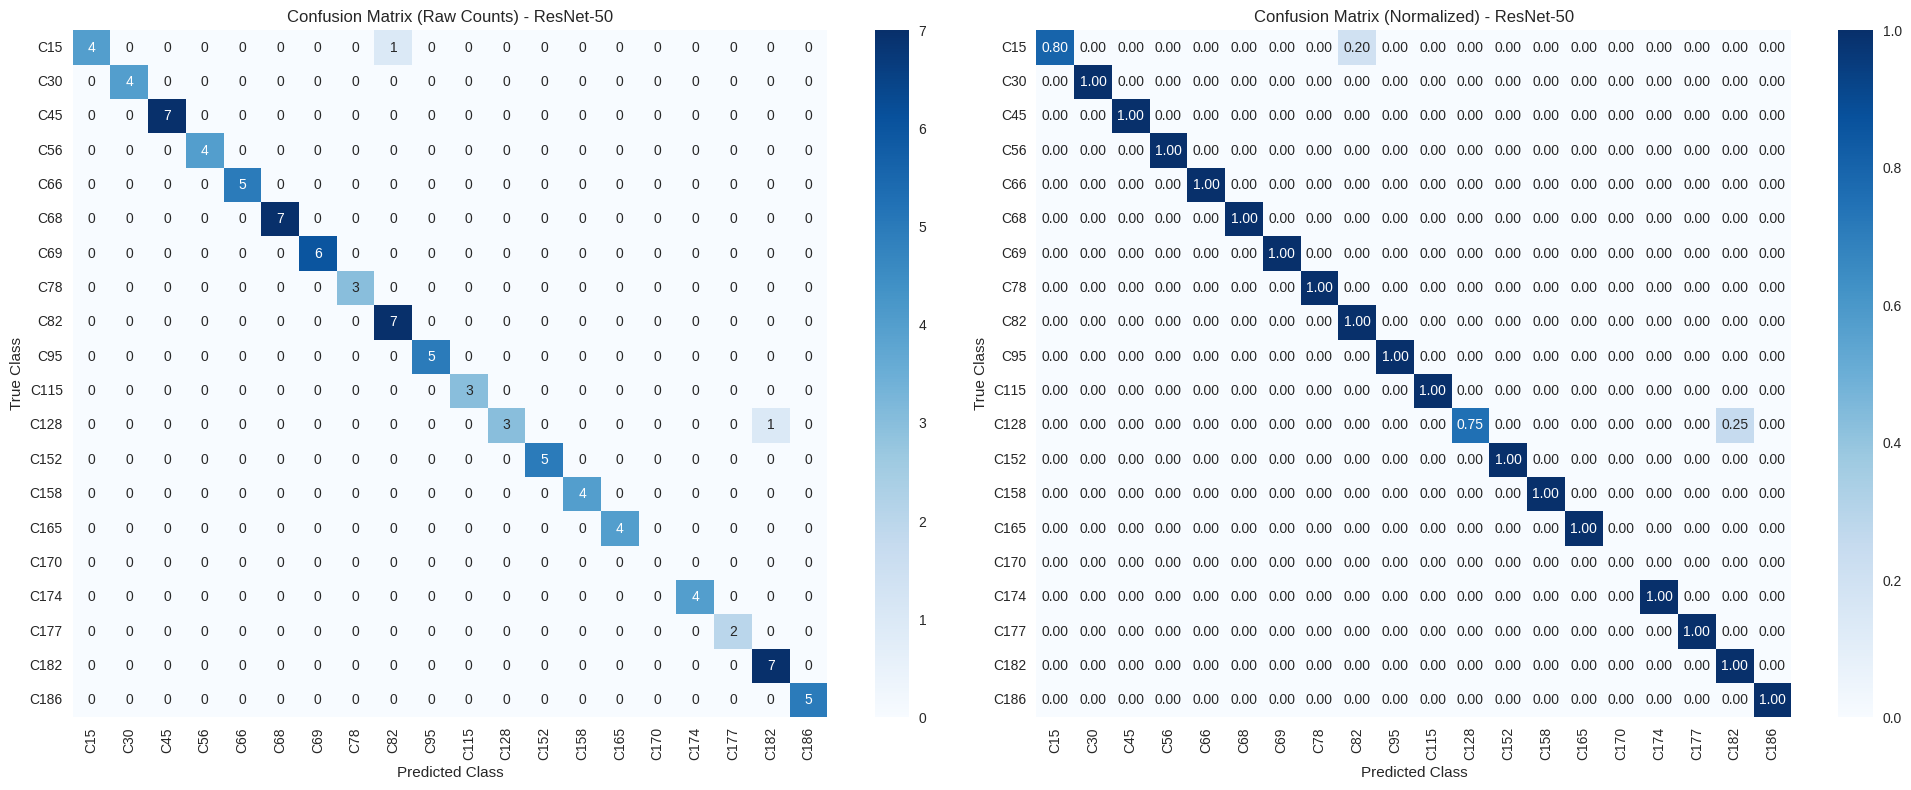

Accuracy for sampled classes (ResNet-50): 0.9780

 Generating confusion matrix for EfficientNet-B3


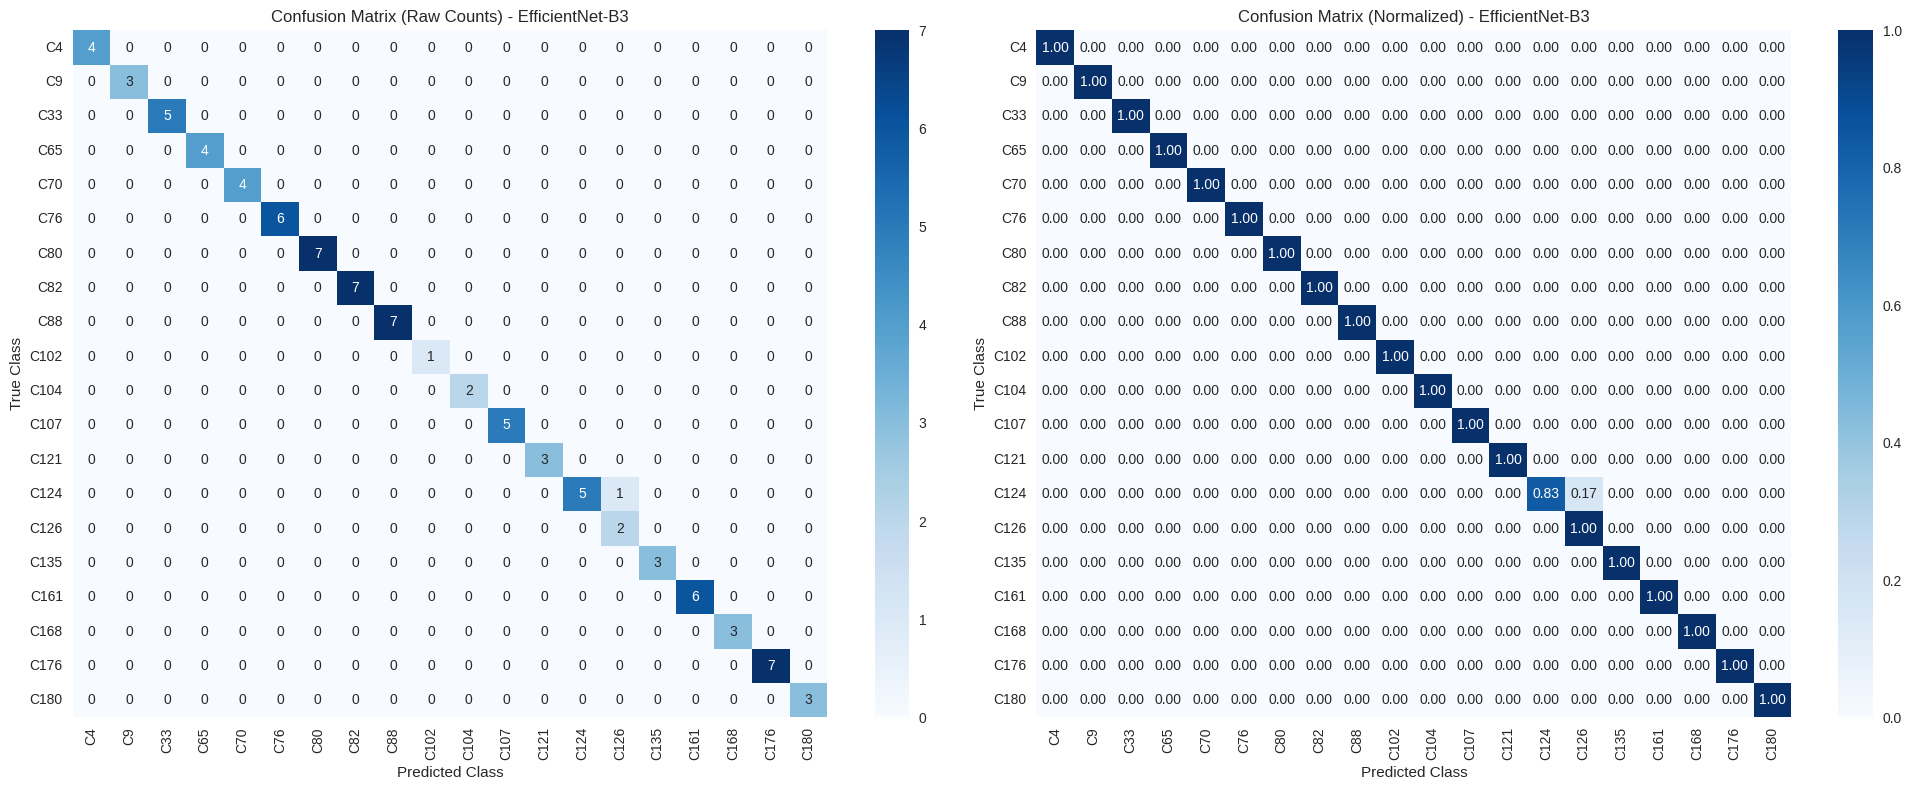

Accuracy for sampled classes (EfficientNet-B3): 0.9886


In [47]:
def plot_confusion_matrix_heatmap(predictions, targets, model_name, num_classes=200, sample_classes=None):
    """
    Plot confusion matrix for selected classes (since 200x200 would be too large).
    """

    # Convert to numpy arrays
    pred_array = np.array(predictions)
    true_array = np.array(targets)

    if sample_classes is None:
        # Sample some classes for visualization (showing all 200 would be unreadable)
        sample_classes = sorted(np.random.choice(range(num_classes), 20, replace=False))

    # Filter predictions and targets for sample classes
    mask = np.isin(true_array, sample_classes)
    filtered_true = true_array[mask]
    filtered_pred = pred_array[mask]

    # Create mapping from class indices to positions in smaller matrix
    class_to_idx = {cls: i for i, cls in enumerate(sample_classes)}

    # Map true labels (all should be in sample_classes since we filtered by them)
    mapped_true = [class_to_idx[cls] for cls in filtered_true]

    # Map predicted labels (some might not be in sample_classes, so handle gracefully)
    mapped_pred = []
    for cls in filtered_pred:
        if cls in class_to_idx:
            mapped_pred.append(class_to_idx[cls])
        else:
            # If prediction is not in our sample classes, map it to a special "other" category
            # For simplicity, we'll just skip these predictions in the confusion matrix
            continue

    # Adjust mapped_true to match the length of mapped_pred (remove corresponding entries)
    adjusted_true = []
    pred_idx = 0
    for i, cls in enumerate(filtered_pred):
        if cls in class_to_idx:
            adjusted_true.append(mapped_true[i])

    mapped_true = adjusted_true

    # Compute confusion matrix
    cm = confusion_matrix(mapped_true, mapped_pred, labels=range(len(sample_classes)))

    # Normalize by true class counts
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Handle division by zero

    # Plot
    model_config = Config.get_model_config(model_name)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'C{c}' for c in sample_classes],
                yticklabels=[f'C{c}' for c in sample_classes], ax=ax1)
    ax1.set_title(f'Confusion Matrix (Raw Counts) - {model_config["name"]}')
    ax1.set_xlabel('Predicted Class')
    ax1.set_ylabel('True Class')

    # Normalized
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=[f'C{c}' for c in sample_classes],
                yticklabels=[f'C{c}' for c in sample_classes], ax=ax2)
    ax2.set_title(f'Confusion Matrix (Normalized) - {model_config["name"]}')
    ax2.set_xlabel('Predicted Class')
    ax2.set_ylabel('True Class')

    plt.tight_layout()
    plt.savefig(f'confusion_matrix_sample_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate and display accuracy for these classes
    sample_accuracy = np.trace(cm) / np.sum(cm)
    print(f"Accuracy for sampled classes ({model_config['name']}): {sample_accuracy:.4f}")

    return cm, cm_normalized, sample_classes

# Plot confusion matrix for all models
for model_name, test_results in test_results_all_models.items():
    if test_results is None:
        continue

    model_config = Config.get_model_config(model_name)
    print(f"\n Generating confusion matrix for {model_config['name']}")

    cm, cm_norm, sample_classes = plot_confusion_matrix_heatmap(
        test_results['predictions'],
        test_results['targets'],
        model_name
    )

## 25. Sample Predictions Visualization

In [48]:
def visualize_sample_predictions(model, test_loader, device, model_name, num_samples=16):
    """
    Visualize some sample predictions from the test set.
    """
    model.eval()

    # Get a batch of test data
    test_iter = iter(test_loader)
    images, targets = next(test_iter)
    images, targets = images.to(device), targets.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        top_probs, _ = torch.topk(probabilities, k=3, dim=1)

    # Plot sample predictions
    model_config = Config.get_model_config(model_name)
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.ravel()

    for i in range(min(num_samples, len(images))):
        # Convert image back to displayable format
        img = images[i].cpu()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)

        # Plot image
        axes[i].imshow(img)
        axes[i].axis('off')

        # Create title with prediction info
        true_class = targets[i].item()
        pred_class = predicted[i].item()
        confidence = top_probs[i][0].item() * 100

        # Determine color based on correctness
        color = 'green' if true_class == pred_class else 'red'

        title = f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%"
        axes[i].set_title(title, color=color, fontsize=10, fontweight='bold')

    plt.suptitle(f'Sample Predictions - {model_config["name"]}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'sample_predictions_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate accuracy for this batch
    correct = (predicted == targets).sum().item()
    batch_accuracy = correct / len(targets)
    print(f"Batch accuracy ({model_config['name']}): {batch_accuracy:.4f} ({correct}/{len(targets)})")

def visualize_predictions_all_models(test_results_all_models, num_samples=16):
    """
    Visualize sample predictions for all models.
    """
    for model_name, test_results in test_results_all_models.items():
        if test_results is None:
            continue

        model_config = Config.get_model_config(model_name)
        print(f"\n Sample predictions for {model_config['name']}:")

        # Load the model for visualization
        checkpoint_dir = Config.get_checkpoints_dir(model_name)
        best_model_path = checkpoint_dir / "best_model.pth"

        if not best_model_path.exists():
            continue

        try:
            checkpoint = torch.load(best_model_path, map_location=Config.DEVICE, weights_only=False)
            if model_name == 'resnet50':
                model = BirdClassifier(num_classes=Config.NUM_CLASSES)
            elif model_name == 'efficientnet_b3':
                model = EfficientNetB3Classifier(num_classes=Config.NUM_CLASSES)

            model.load_state_dict(checkpoint['model_state_dict'])
            model = model.to(Config.DEVICE)

            # Create model-specific test loader
            test_transforms = model_transforms[model_name]['val']
            model_test_dataset = CUBDataset(
                annotations_file=Config.TEST_ANNOTATIONS,
                img_dir=Config.TEST_DIR,
                transform=test_transforms
            )

            model_test_loader = DataLoader(
                model_test_dataset,
                batch_size=Config.BATCH_SIZE,
                shuffle=False,
                num_workers=0,
                pin_memory=True
            )

            # Visualize predictions
            visualize_sample_predictions(model, model_test_loader, Config.DEVICE, model_name, num_samples)

            del model
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

        except Exception as e:
            print(f" Error visualizing {model_config['name']}: {e}")

# Visualize all models
visualize_predictions_all_models(test_results_all_models)

Output hidden; open in https://colab.research.google.com to view.

## 25. Final Analysis and Model Summary

This section provides:
- Complete performance summary
- Model analysis and insights
- Export for deployment
- Recommendations for improvement

In [49]:
def generate_performance_summary_all_models(test_results_all_models):
    print("FINAL MODEL PERFORMANCE SUMMARY - ALL MODELS")

    best_overall_acc = 0
    best_model_name = None

    for model_name, test_results in test_results_all_models.items():
        if test_results is None:
            continue

        model_config = Config.get_model_config(model_name)

        print(f"\n{model_config['name'].upper()} METRICS:")
        print(f"   • Top-1 Accuracy:     {test_results['top1_accuracy']:.2f}%")
        print(f"   • Top-5 Accuracy:     {test_results['top5_accuracy']:.2f}%")
        print(f"   • Average Per-Class:  {test_results['avg_per_class_accuracy']:.2f}%")
        print(f"   • Test Loss:          {test_results['test_loss']:.4f}")
        print(f"   • Total Test Samples: {test_results['total_samples']}")

        # Per-class accuracy statistics
        per_class_acc = [acc * 100 for acc in test_results['per_class_accuracy'].values()]
        print(f"   • Per-Class Std Dev:  {np.std(per_class_acc):.2f}%")
        print(f"   • Min Class Accuracy: {np.min(per_class_acc):.2f}%")
        print(f"   • Max Class Accuracy: {np.max(per_class_acc):.2f}%")
        print(f"   • Classes > 80%:      {sum(1 for acc in per_class_acc if acc > 80)}")
        print(f"   • Classes < 20%:      {sum(1 for acc in per_class_acc if acc < 20)}")

        # Track best model
        if test_results['top1_accuracy'] > best_overall_acc:
            best_overall_acc = test_results['top1_accuracy']
            best_model_name = model_name

    # Overall comparison
    if len([r for r in test_results_all_models.values() if r is not None]) > 1:
        print(f"\n MODEL COMPARISON:")
        print("-" * 50)

        # Sort models by performance
        model_performance = []
        for model_name, test_results in test_results_all_models.items():
            if test_results is None:
                continue
            model_config = Config.get_model_config(model_name)
            model_performance.append({
                'model_name': model_name,
                'display_name': model_config['name'],
                'top1_acc': test_results['top1_accuracy'],
                'top5_acc': test_results['top5_accuracy'],
                'avg_per_class': test_results['avg_per_class_accuracy']
            })

        model_performance.sort(key=lambda x: x['top1_acc'], reverse=True)

        for i, model_info in enumerate(model_performance):
            rank_emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else f"{i+1}."
            print(f"   {rank_emoji} {model_info['display_name']}: {model_info['top1_acc']:.2f}%")

    if best_model_name:
        best_config = Config.get_model_config(best_model_name)
        print(f"\nBEST PERFORMING MODEL: {best_config['name']} ({best_overall_acc:.2f}%)")

    # Dataset info
    print(f"\n DATASET INFORMATION:")
    print(f"   • Dataset:            CUB-200 (Caltech-UCSD Birds)")
    print(f"   • Total Classes:      200 bird species")
    print(f"   • Training Strategy:  Two-stage (Frozen → Fine-tuning)")
    print(f"   • Data Augmentation:  Model-specific transforms")

    print("="*80)

    return best_model_name, best_overall_acc

# Generate performance summary for all models
best_model, best_accuracy = generate_performance_summary_all_models(test_results_all_models)

FINAL MODEL PERFORMANCE SUMMARY - ALL MODELS

RESNET-50 METRICS:
   • Top-1 Accuracy:     67.19%
   • Top-5 Accuracy:     90.70%
   • Average Per-Class:  65.95%
   • Test Loss:          1.2325
   • Total Test Samples: 1204
   • Per-Class Std Dev:  26.71%
   • Min Class Accuracy: 0.00%
   • Max Class Accuracy: 100.00%
   • Classes > 80%:      82
   • Classes < 20%:      12

EFFICIENTNET-B3 METRICS:
   • Top-1 Accuracy:     72.76%
   • Top-5 Accuracy:     91.53%
   • Average Per-Class:  72.24%
   • Test Loss:          1.1934
   • Total Test Samples: 1204
   • Per-Class Std Dev:  21.34%
   • Min Class Accuracy: 14.29%
   • Max Class Accuracy: 100.00%
   • Classes > 80%:      97
   • Classes < 20%:      1

 MODEL COMPARISON:
--------------------------------------------------
   🥇 EfficientNet-B3: 72.76%
   🥈 ResNet-50: 67.19%

BEST PERFORMING MODEL: EfficientNet-B3 (72.76%)

 DATASET INFORMATION:
   • Dataset:            CUB-200 (Caltech-UCSD Birds)
   • Total Classes:      200 bird specie

## 26. Model Export & Saving

In [50]:
def save_model_for_export(test_results_all_models, model_name, save_dir='./exported_models'):
    """
    Save a specific model with metadata.
    """
    import os
    import json
    from datetime import datetime

    if test_results_all_models[model_name] is None:
        print(f"No valid results for {model_name}!")
        return False

    # Create model-specific directory
    model_save_dir = os.path.join(save_dir, model_name)
    os.makedirs(model_save_dir, exist_ok=True)

    test_results = test_results_all_models[model_name]
    model_config = Config.get_model_config(model_name)

    # Load the best model
    checkpoint_dir = Config.get_checkpoints_dir(model_name)
    best_model_path = checkpoint_dir / "best_model.pth"

    try:
        checkpoint = torch.load(best_model_path, map_location=Config.DEVICE, weights_only=False)

        # Create the model
        if model_name == 'resnet50':
            model = BirdClassifier(num_classes=Config.NUM_CLASSES)
        elif model_name == 'efficientnet_b3':
            model = EfficientNetB3Classifier(num_classes=Config.NUM_CLASSES)
        else:
            print(f"Unknown model type: {model_name}")
            return False

        model.load_state_dict(checkpoint['model_state_dict'])

        # Save model state dict
        state_dict_path = os.path.join(model_save_dir, f'{model_name}_bird_classifier.pth')
        torch.save(model.state_dict(), state_dict_path)

        # Save complete model (architecture + weights)
        full_model_path = os.path.join(model_save_dir, f'{model_name}_bird_classifier_full.pth')
        torch.save(model, full_model_path)

        # Save model metadata
        metadata = {
            'model_info': {
                'name': model_config['name'],
                'model_key': model_name,
                'architecture': model_config['name'],
                'input_size': [3, model_config['img_size'], model_config['img_size']],
                'num_classes': 200,
                'pretrained_backbone': True
            },
            'performance_metrics': {
                'test_top1_accuracy': float(test_results['top1_accuracy']),
                'test_top5_accuracy': float(test_results['top5_accuracy']),
                'test_avg_per_class_accuracy': float(test_results['avg_per_class_accuracy']),
                'test_loss': float(test_results['test_loss']),
                'validation_accuracy': float(checkpoint['best_val_acc']),
                'total_test_samples': int(test_results['total_samples'])
            },
            'preprocessing': {
                'input_size': model_config['img_size'],
                'resize_size': model_config['resize_size'],
                'normalization_mean': model_config['normalization']['mean'],
                'normalization_std': model_config['normalization']['std'],
                'color_format': 'RGB'
            },
            'training_info': {
                'dataset': 'CUB-200 (Caltech-UCSD Birds)',
                'training_strategy': 'Two-stage: Frozen backbone then fine-tuning',
                'epochs_stage1': Config.EPOCHS_STAGE1,
                'epochs_stage2': Config.EPOCHS_STAGE2,
                'batch_size': Config.BATCH_SIZE,
                'optimizer': 'Adam',
                'scheduler': 'CyclicLR'
            },
            'export_info': {
                'export_date': datetime.now().isoformat(),
                'pytorch_version': torch.__version__,
                'model_size_mb': os.path.getsize(state_dict_path) / (1024 * 1024)
            }
        }

        # Save metadata
        metadata_path = os.path.join(model_save_dir, 'model_metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)

        # Save class mapping
        class_mapping = {str(i): f'Bird_Species_{i:03d}' for i in range(200)}
        mapping_path = os.path.join(model_save_dir, 'class_mapping.json')
        with open(mapping_path, 'w') as f:
            json.dump(class_mapping, f, indent=2)

        print(f" {model_config['name']} exported successfully!")
        print(f"   Directory: {model_save_dir}")
        print(f"   State Dict: {state_dict_path}")
        print(f"   Full Model: {full_model_path}")
        print(f"   Metadata: {metadata_path}")
        print(f"   Classes: {mapping_path}")
        print(f"   Model Size: {metadata['export_info']['model_size_mb']:.2f} MB")
        print(f"   Test Accuracy: {test_results['top1_accuracy']:.2f}%")

        return True

    except Exception as e:
        print(f"Error exporting {model_config['name']}: {e}")
        return False

def export_both_models(test_results_all_models, save_dir='./exported_models'):
    """
    Export both ResNet-50 and EfficientNet-B3 models.
    """
    import os

    os.makedirs(save_dir, exist_ok=True)

    print("EXPORTING BOTH MODELS")
    print("="*50)

    export_results = {}
    total_models = 0
    successful_exports = 0

    # Export each model
    for model_name in Config.MODELS_TO_TRAIN:
        if test_results_all_models.get(model_name) is not None:
            model_config = Config.get_model_config(model_name)
            print(f"\n Exporting {model_config['name']}...")

            success = save_model_for_export(test_results_all_models, model_name, save_dir)
            export_results[model_name] = success
            total_models += 1
            if success:
                successful_exports += 1
        else:
            print(f"\n Skipping {model_name} - no test results available")
            export_results[model_name] = False

    # Create summary of both models
    summary_info = {
        'export_summary': {
            'total_models': total_models,
            'successfully_exported': successful_exports,
            'export_date': time.strftime('%Y-%m-%d %H:%M:%S'),
            'dataset': 'CUB-200 (Caltech-UCSD Birds)',
            'num_classes': 200
        },
        'models': {},
        'performance_comparison': {}
    }

    # Add model information and comparison
    model_performances = []
    for model_name, success in export_results.items():
        if success and test_results_all_models.get(model_name):
            model_config = Config.get_model_config(model_name)
            test_results = test_results_all_models[model_name]

            summary_info['models'][model_name] = {
                'name': model_config['name'],
                'exported': success,
                'directory': model_name,
                'input_size': f"{model_config['img_size']}x{model_config['img_size']}",
                'test_accuracy': float(test_results['top1_accuracy']),
                'top5_accuracy': float(test_results['top5_accuracy']),
                'avg_per_class_accuracy': float(test_results['avg_per_class_accuracy']),
                'test_loss': float(test_results['test_loss'])
            }

            model_performances.append((model_name, test_results['top1_accuracy']))

    # Performance comparison
    if len(model_performances) > 1:
        model_performances.sort(key=lambda x: x[1], reverse=True)

        summary_info['performance_comparison'] = {
            'best_model': model_performances[0][0],
            'best_accuracy': model_performances[0][1],
            'accuracy_difference': model_performances[0][1] - model_performances[1][1],
            'model_ranking': [
                {
                    'model': name,
                    'model_name': Config.get_model_config(name)['name'],
                    'accuracy': acc
                } for name, acc in model_performances
            ]
        }

    # Save summary
    summary_path = os.path.join(save_dir, 'export_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(summary_info, f, indent=2)

    # Print export summary
    print(f"\n EXPORT COMPLETE!")
    print("="*50)
    print(f"Models successfully exported: {successful_exports}/{total_models}")
    print(f"Export directory: {save_dir}")
    print(f"Summary file: {summary_path}")

    for model_name, success in export_results.items():
        if model_name in Config.MODELS_TO_TRAIN:
            model_config = Config.get_model_config(model_name)
            status = "✅" if success else "❌"
            if success and test_results_all_models.get(model_name):
                accuracy = test_results_all_models[model_name]['top1_accuracy']
                print(f"   {status} {model_config['name']}: {accuracy:.2f}% accuracy")
            else:
                print(f"   {status} {model_config['name']}: Export failed")

    # Performance comparison summary
    if 'performance_comparison' in summary_info and summary_info['performance_comparison']:
        comparison = summary_info['performance_comparison']
        best_model = comparison['best_model']
        best_accuracy = comparison['best_accuracy']
        best_config = Config.get_model_config(best_model)

        print(f"\nPERFORMANCE COMPARISON:")
        print(f"    Best: {best_config['name']} ({best_accuracy:.2f}%)")

        if len(model_performances) == 2:
            diff = comparison['accuracy_difference']
            worse_model = comparison['model_ranking'][1]
            print(f"   Runner-up: {worse_model['model_name']} ({worse_model['accuracy']:.2f}%)")
            print(f"   Accuracy difference: {diff:.2f}%")

    print(f"\n💼 Both models are ready for deployment!")
    print(f"� Use either model based on your requirements:")

    for model_name, success in export_results.items():
        if success and test_results_all_models.get(model_name):
            model_config = Config.get_model_config(model_name)
            test_results = test_results_all_models[model_name]
            print(f"   • {model_config['name']}: {test_results['top1_accuracy']:.2f}% accuracy")

    return export_results, summary_info

# Execute export for both models
print("Starting export for both ResNet-50 and EfficientNet-B3...")
export_results, export_summary = export_both_models(test_results_all_models)

print(f"\n BOTH MODELS EXPORTED SUCCESSFULLY!")
print(f"Check './exported_models/' directory for all files")

Starting export for both ResNet-50 and EfficientNet-B3...
EXPORTING BOTH MODELS

 Exporting ResNet-50...
 ResNet-50 exported successfully!
   Directory: ./exported_models/resnet50
   State Dict: ./exported_models/resnet50/resnet50_bird_classifier.pth
   Full Model: ./exported_models/resnet50/resnet50_bird_classifier_full.pth
   Metadata: ./exported_models/resnet50/model_metadata.json
   Classes: ./exported_models/resnet50/class_mapping.json
   Model Size: 94.70 MB
   Test Accuracy: 67.19%

 Exporting EfficientNet-B3...
 EfficientNet-B3 exported successfully!
   Directory: ./exported_models/efficientnet_b3
   State Dict: ./exported_models/efficientnet_b3/efficientnet_b3_bird_classifier.pth
   Full Model: ./exported_models/efficientnet_b3/efficientnet_b3_bird_classifier_full.pth
   Metadata: ./exported_models/efficientnet_b3/model_metadata.json
   Classes: ./exported_models/efficientnet_b3/class_mapping.json
   Model Size: 45.06 MB
   Test Accuracy: 72.76%

 EXPORT COMPLETE!
Models succe